In [679]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.backends.backend_pdf
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [605]:
data = pd.read_csv('C:/Users/saleh/Desktop/House Prices/House-Pricing/train.csv')
price = data['SalePrice']

In [381]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


### Lets understand the target variable

In [607]:
print(price.describe())
print('\n')

#compute the kurtosis and skewness of Weekly_Sales
print('Sale Price Skewness:', price.skew())
print('Sale Price Kurtosis:', price.kurt())
print('\n')
if -0.5 <= price.skew() <= 0.5:
    print('Sale Price distribution is approximately symmetric')
elif -0.5 > price.skew() or price.skew() > 0.5:
    print('Sale Price distribution is skewed')

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


Sale Price Skewness: 1.8828757597682129
Sale Price Kurtosis: 6.536281860064529


Sale Price distribution is skewed


#### Visualize the skew in the sale price and remove any outliers if necessary

The upper and lower bounds of possible outliers: -122100.0  and  466075.0


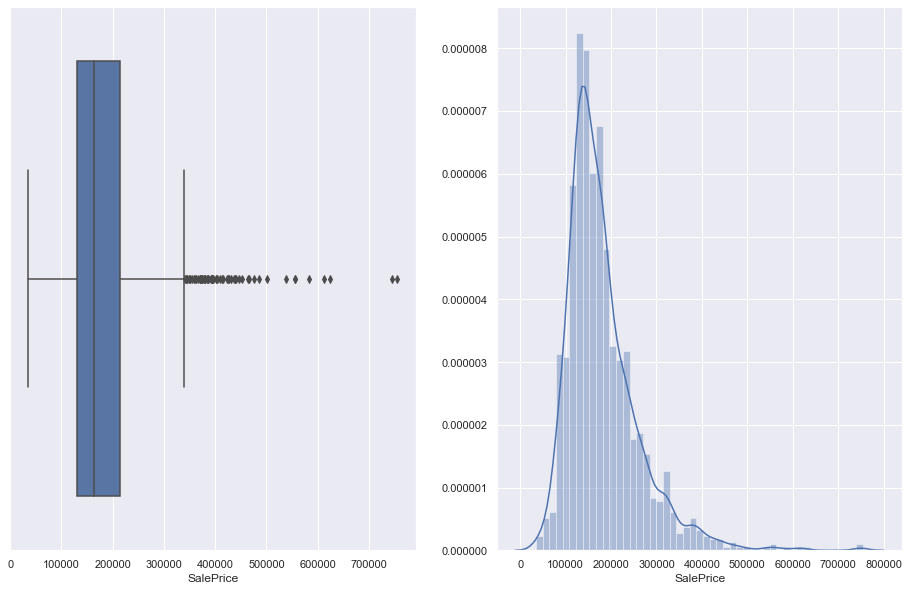

In [608]:
#plot boxplot & distribution plot of the target variable
plt.figure(figsize = (16,10))
plt.subplot(1,2,1)
sns.boxplot(price)
plt.subplot(1,2,2)
sns.distplot(price)

#We use IQR to identify potential outliers. We will use 3*IQR to identify outliers
stats = price.describe()
IQR = stats['75%'] - stats['25%']
upper_bound = stats['75%'] + 3 * IQR
lower_bound = stats['25%'] - 3 * IQR
print('The upper and lower bounds of possible outliers:', lower_bound, ' and ', upper_bound)

Lets check how many observations we have above the outlier threshold limit and drop the outliers from our data.

In [611]:
data[price>upper_bound]

data = data[data['SalePrice'] <= upper_bound]

price = price[price<=upper_bound]

C:\Users\saleh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


## Understand the continuous features in the data

In [613]:
X = data.drop('SalePrice',axis=1)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_data_all = X.select_dtypes(include=numerics)

to_drop = ('MSSubClass MoSold Fireplaces GarageYrBlt YrSold BsmtFullBath BsmtHalfBath HalfBath KitchenAbvGr LotFrontage MasVnrArea').split(' ')
data_num = num_data_all.drop(to_drop,axis=1)

In [614]:
data_num.describe()


,Id,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,TotRmsAbvGrd,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
count,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,...,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000
mean,729.962707,10431.325276,6.071823,5.576657,1971.080110,1984.715470,437.830801,46.562845,564.221685,1048.615331,...,6.484807,1.756906,469.889503,93.546961,46.221685,22.136050,3.437845,14.507597,2.398481,43.849448
std,422.015087,9921.133236,1.353929,1.112687,30.123527,20.656816,447.376015,161.417653,438.851641,427.285851,...,1.587282,0.741890,211.660605,124.671113,66.125594,61.339213,29.436993,54.413502,37.638471,498.160083
min,1.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,364.750000,7500.000000,5.000000,5.000000,1954.000000,1966.000000,0.000000,0.000000,220.750000,794.000000,...,5.000000,1.000000,326.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,728.500000,9444.500000,6.000000,5.000000,1972.000000,1993.000000,381.000000,0.000000,474.000000,990.000000,...,6.000000,2.000000,478.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1095.250000,11500.000000,7.000000,6.000000,2000.000000,2004.000000,705.250000,0.000000,806.000000,1284.000000,...,7.000000,2.000000,576.000000,168.000000,66.500000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1460.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,5644.000000,1474.000000,2336.000000,6110.000000,...,14.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000


C:\Users\saleh\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\saleh\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\saleh\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Users\saleh\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\saleh\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\saleh\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotl

C:\Users\saleh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10
C:\Users\saleh\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\function_base.py:159: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\saleh\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start
C:\Users\saleh\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:421: RuntimeWarning: invalid value encountered in greater
  if np.any(bin_edges[:-1] > bin_edges[1:]):
C:\Users\saleh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10
C:\Users\saleh\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\function_base.py:159: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\saleh\AppData

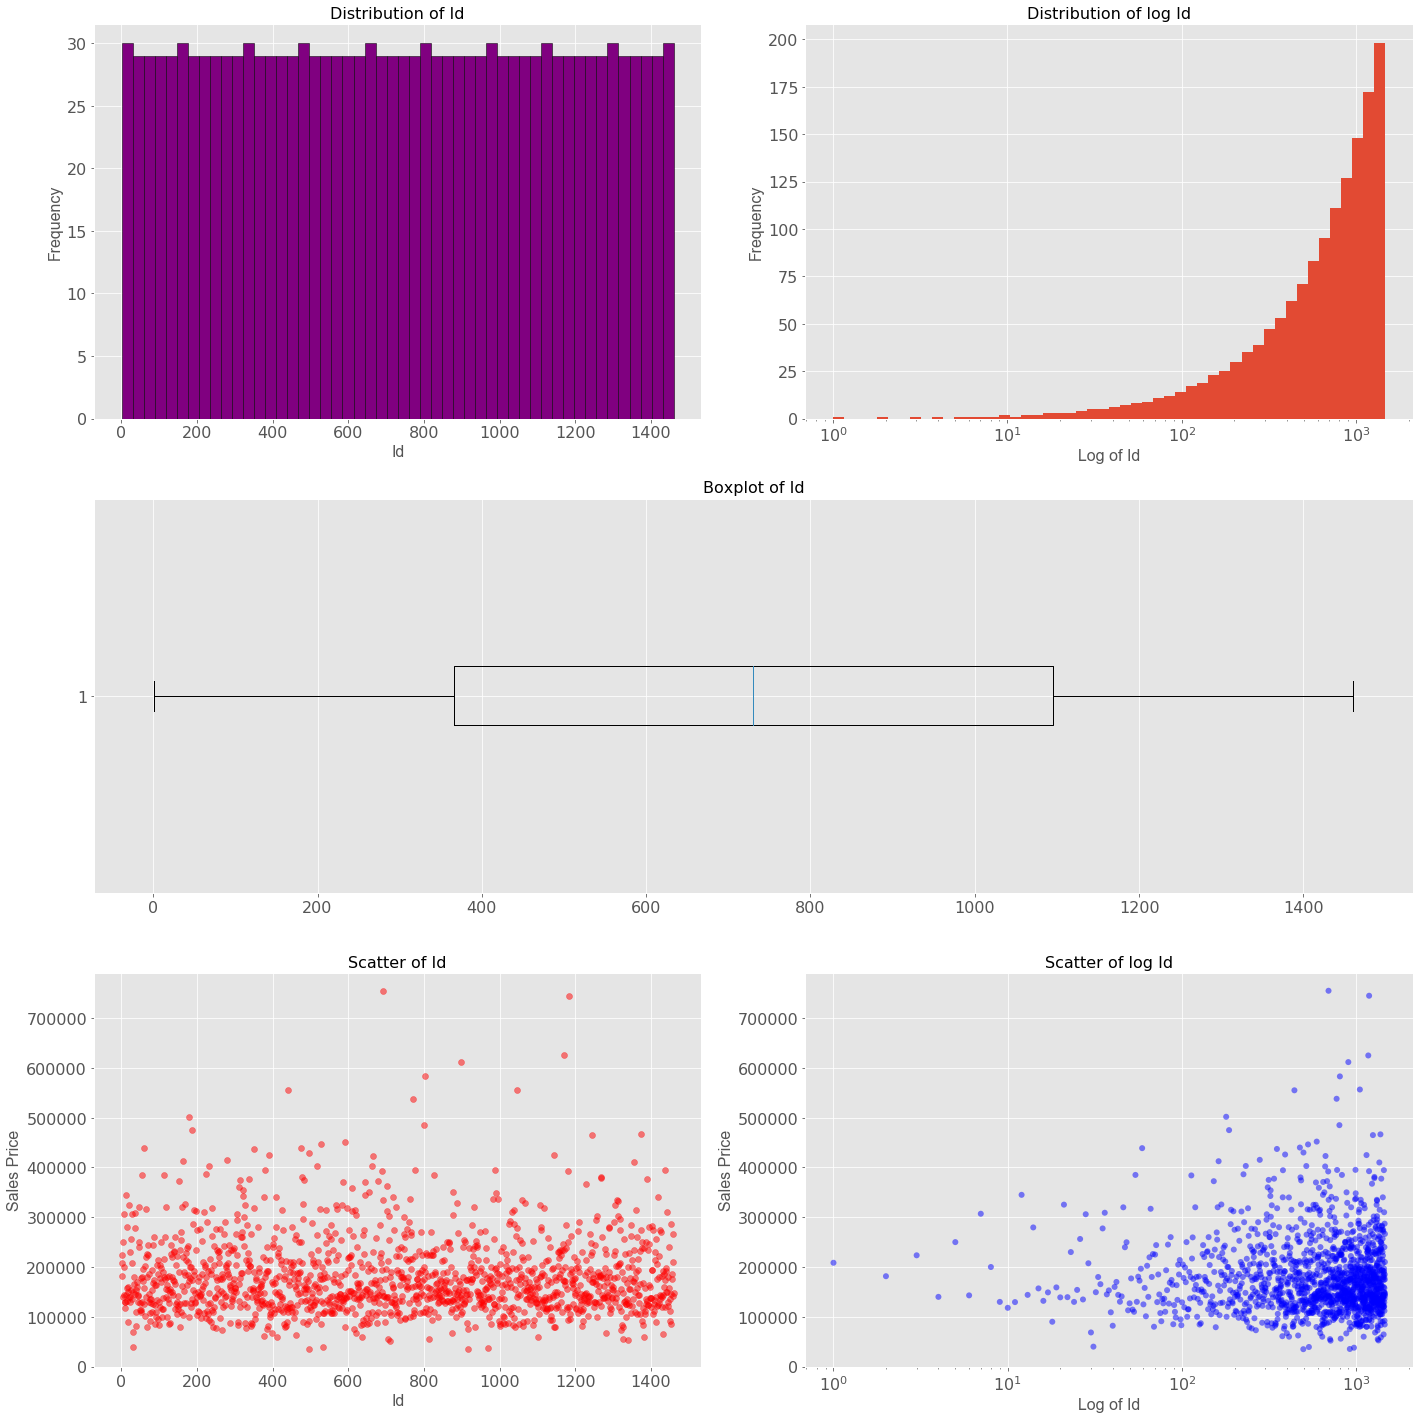

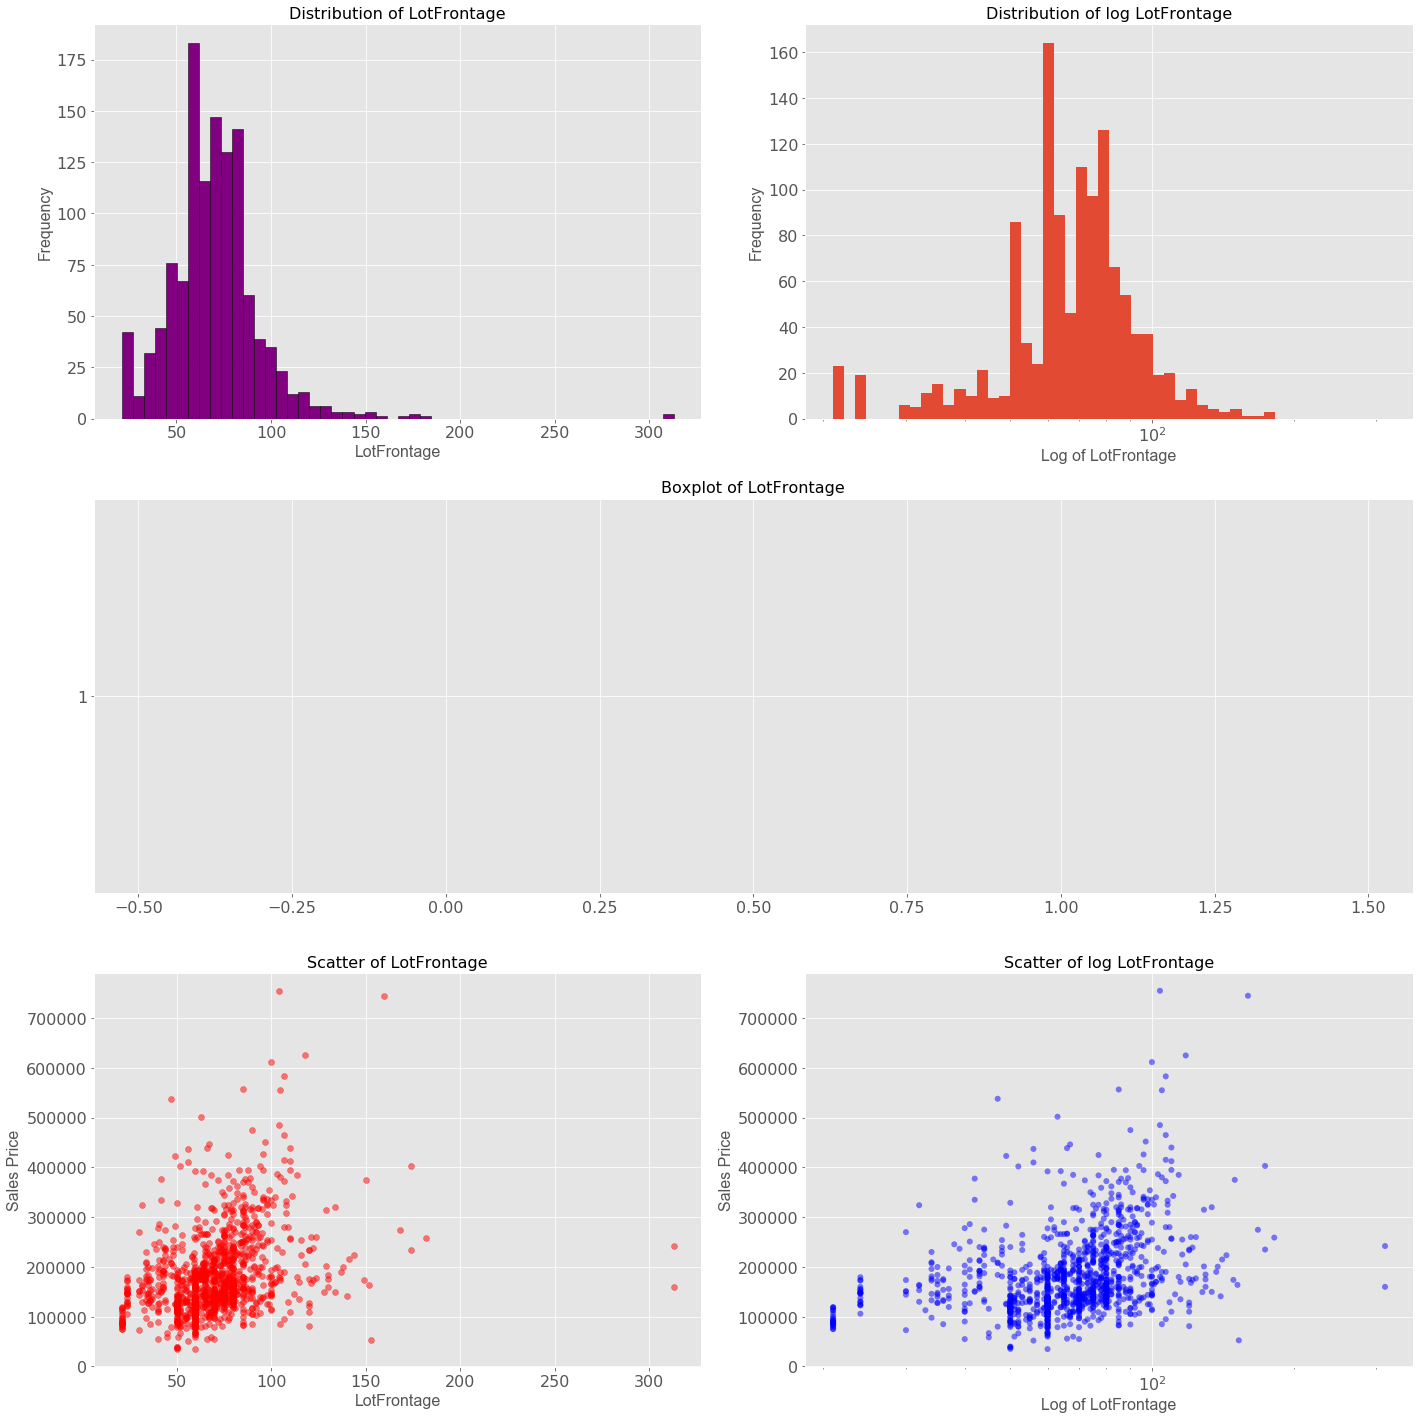

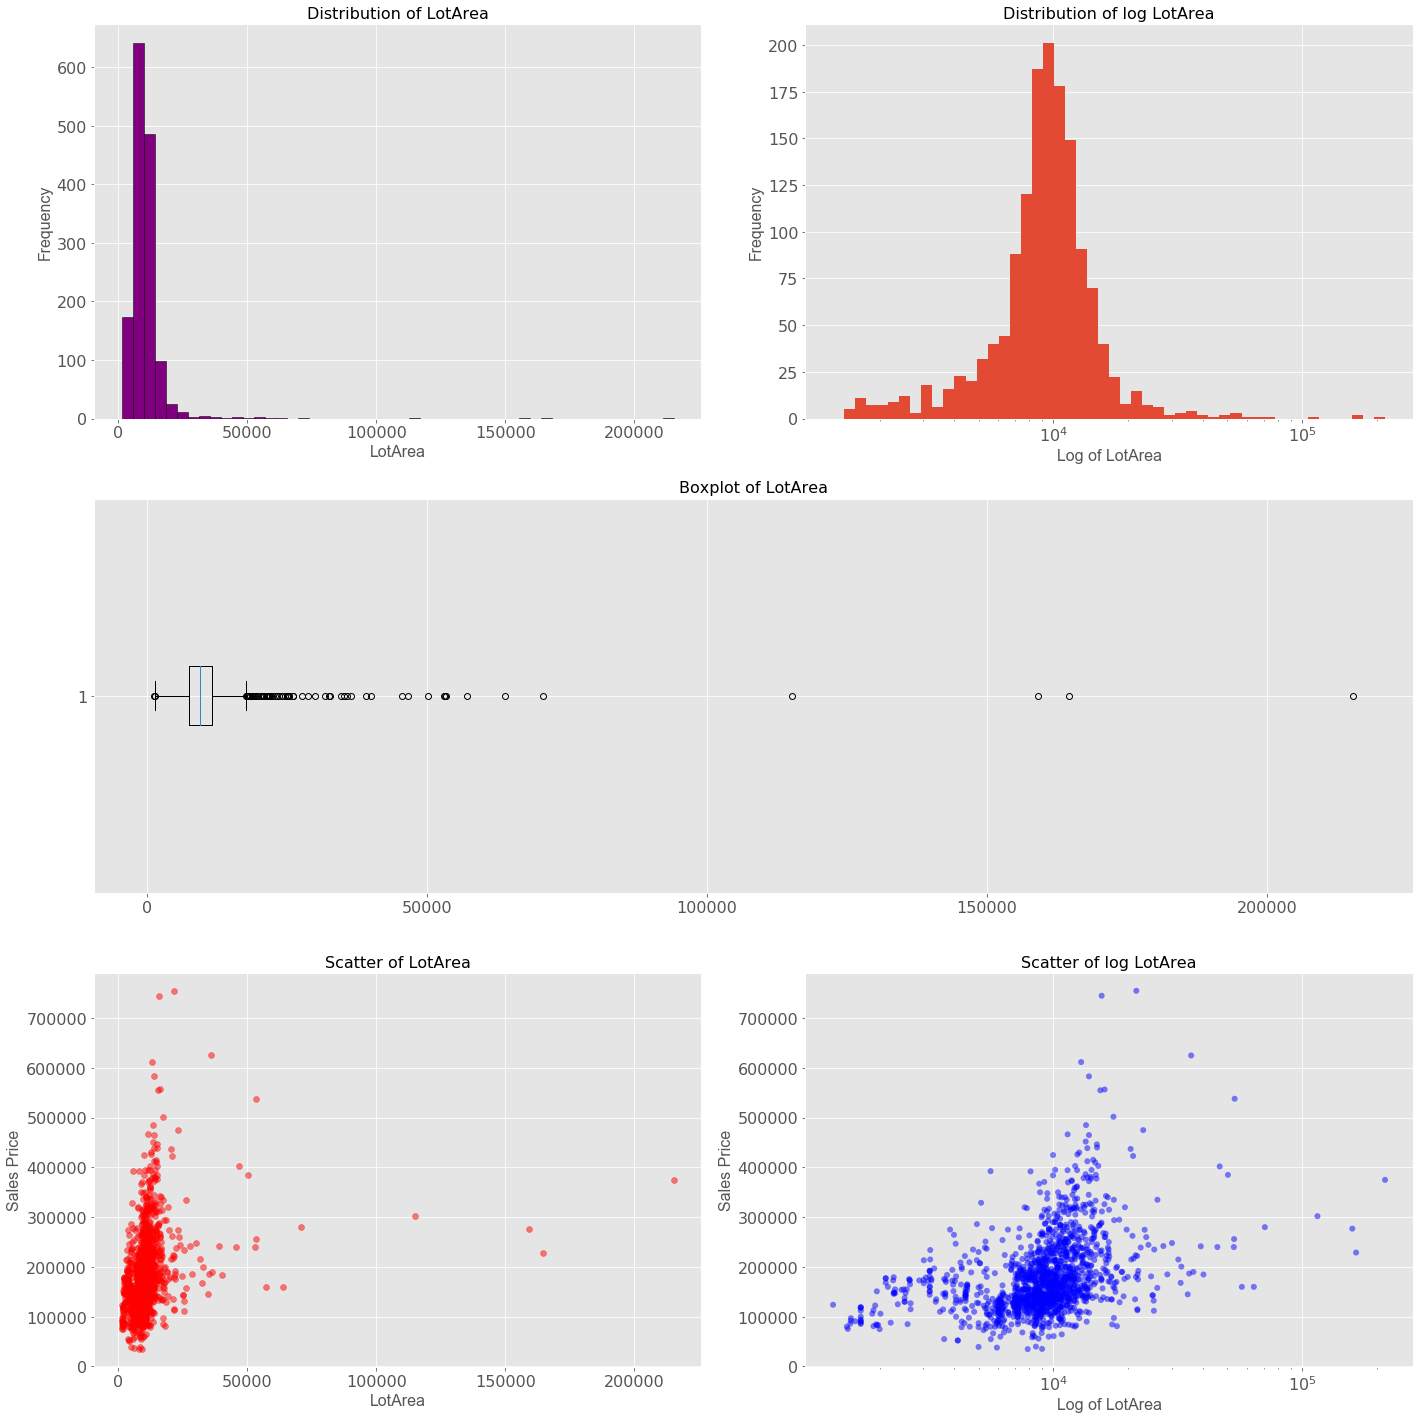

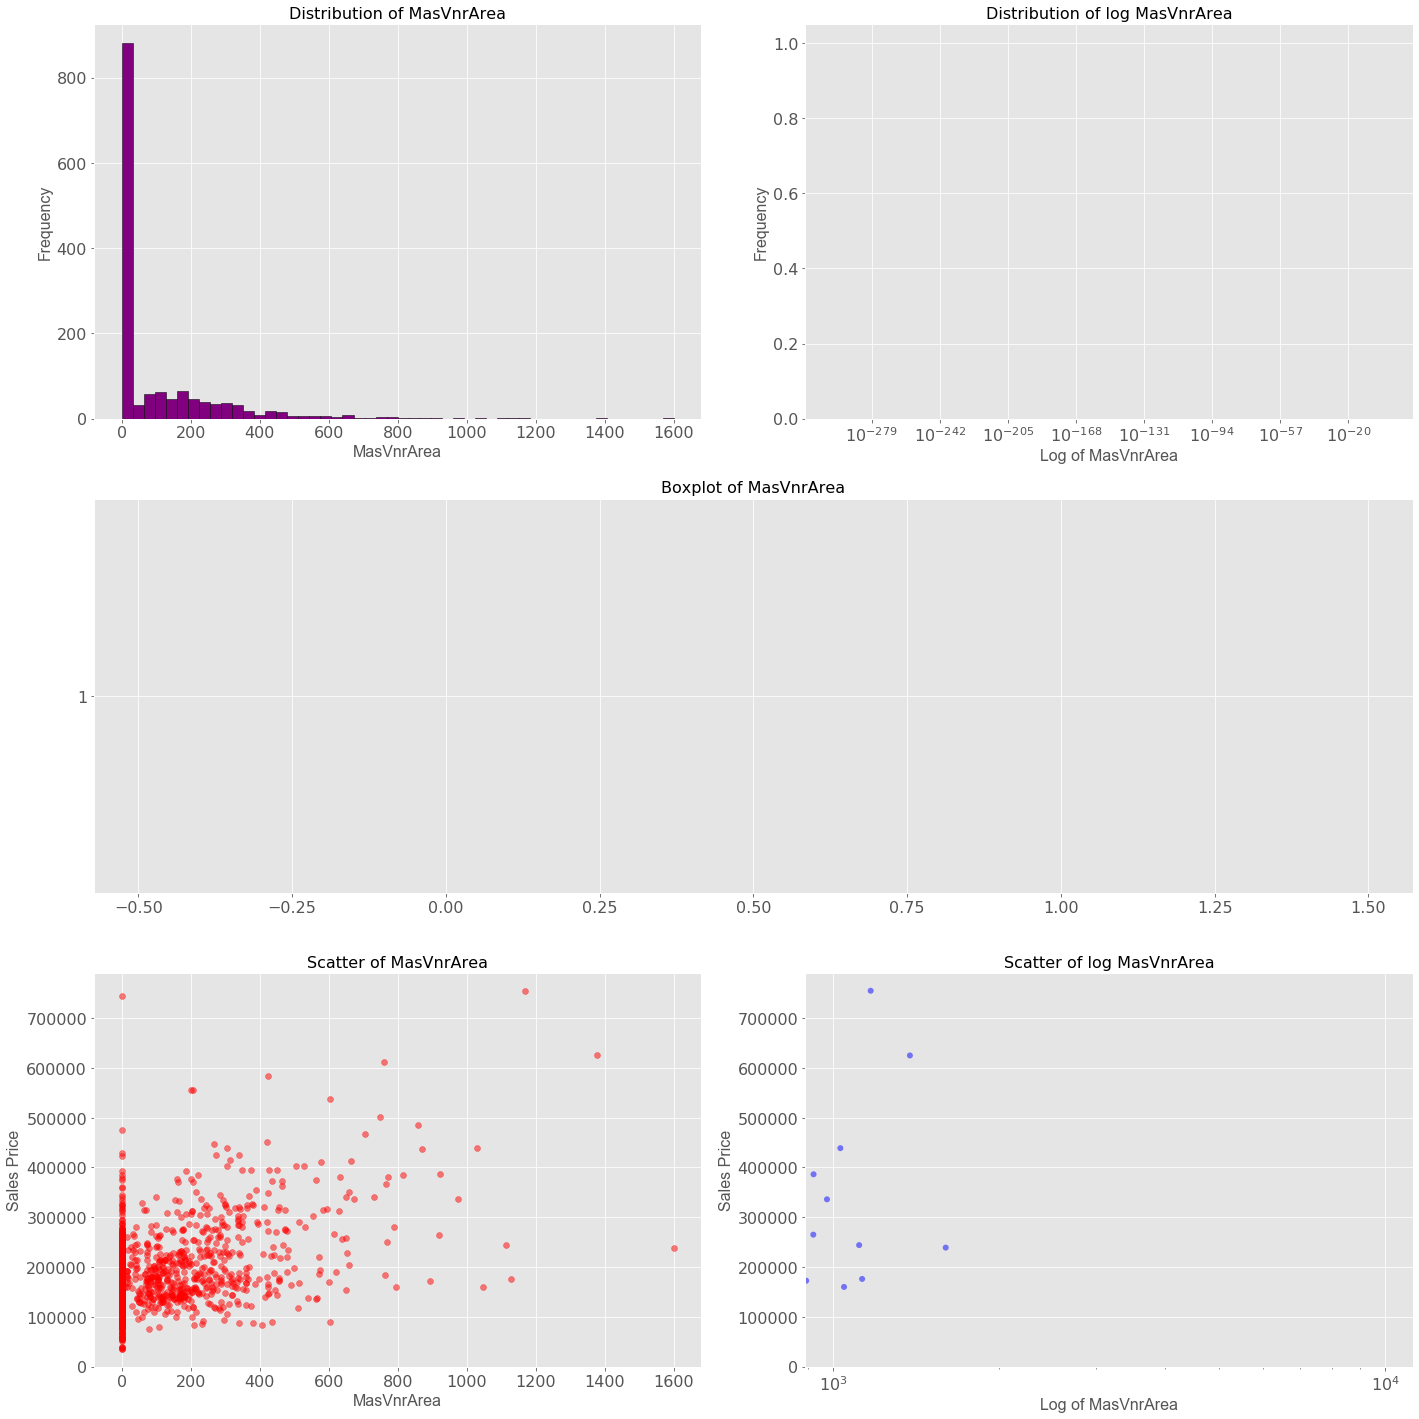

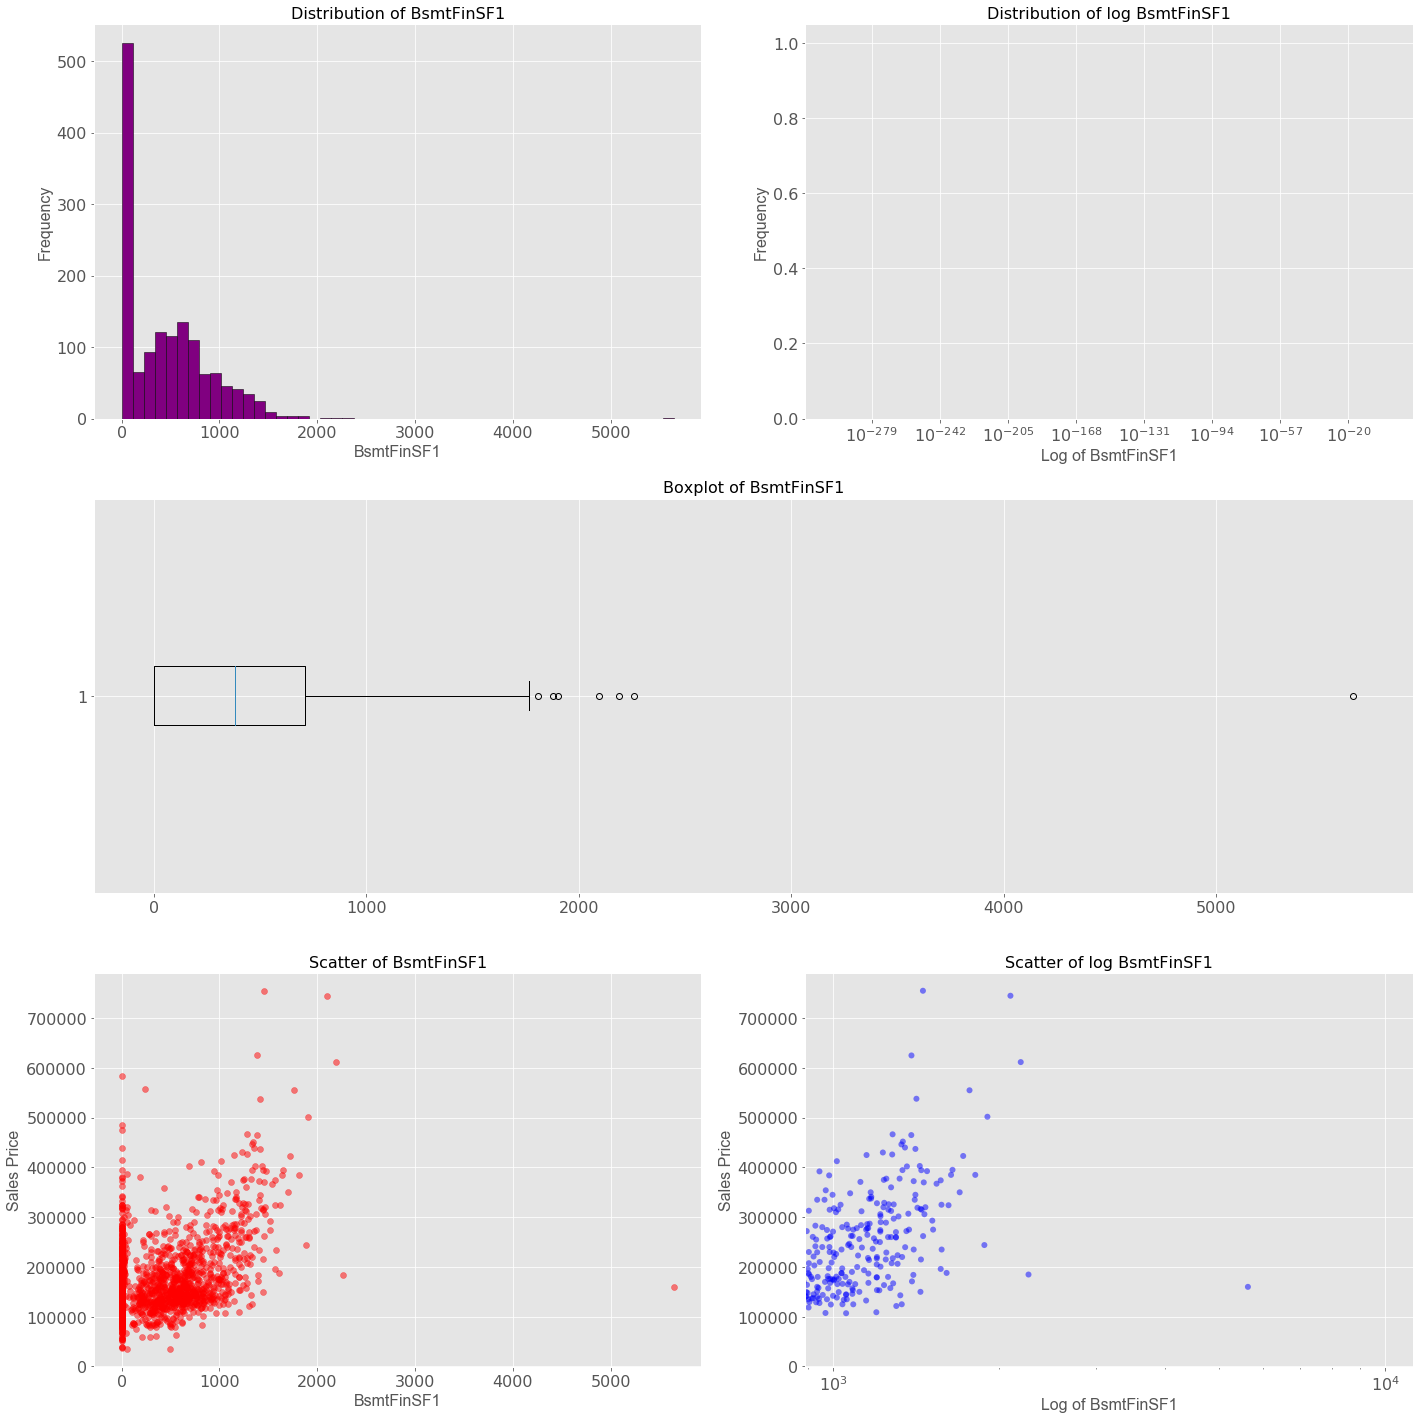

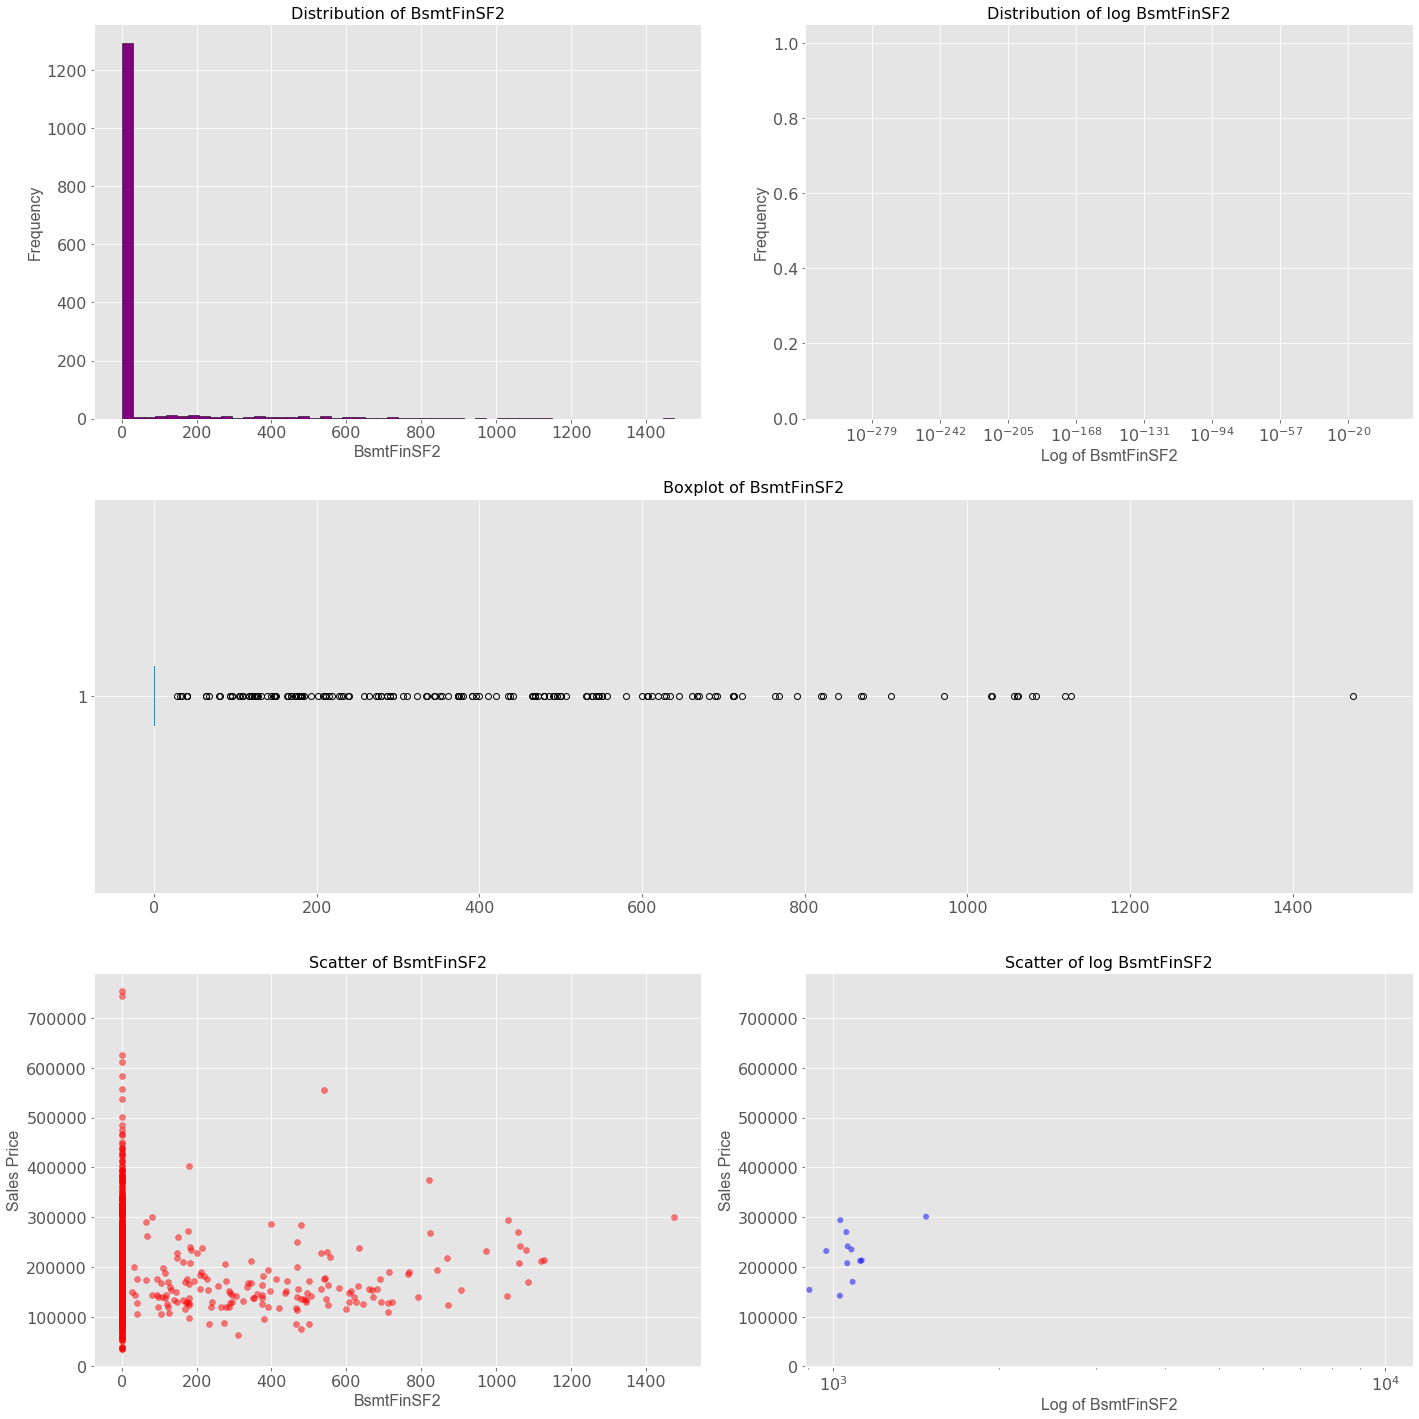

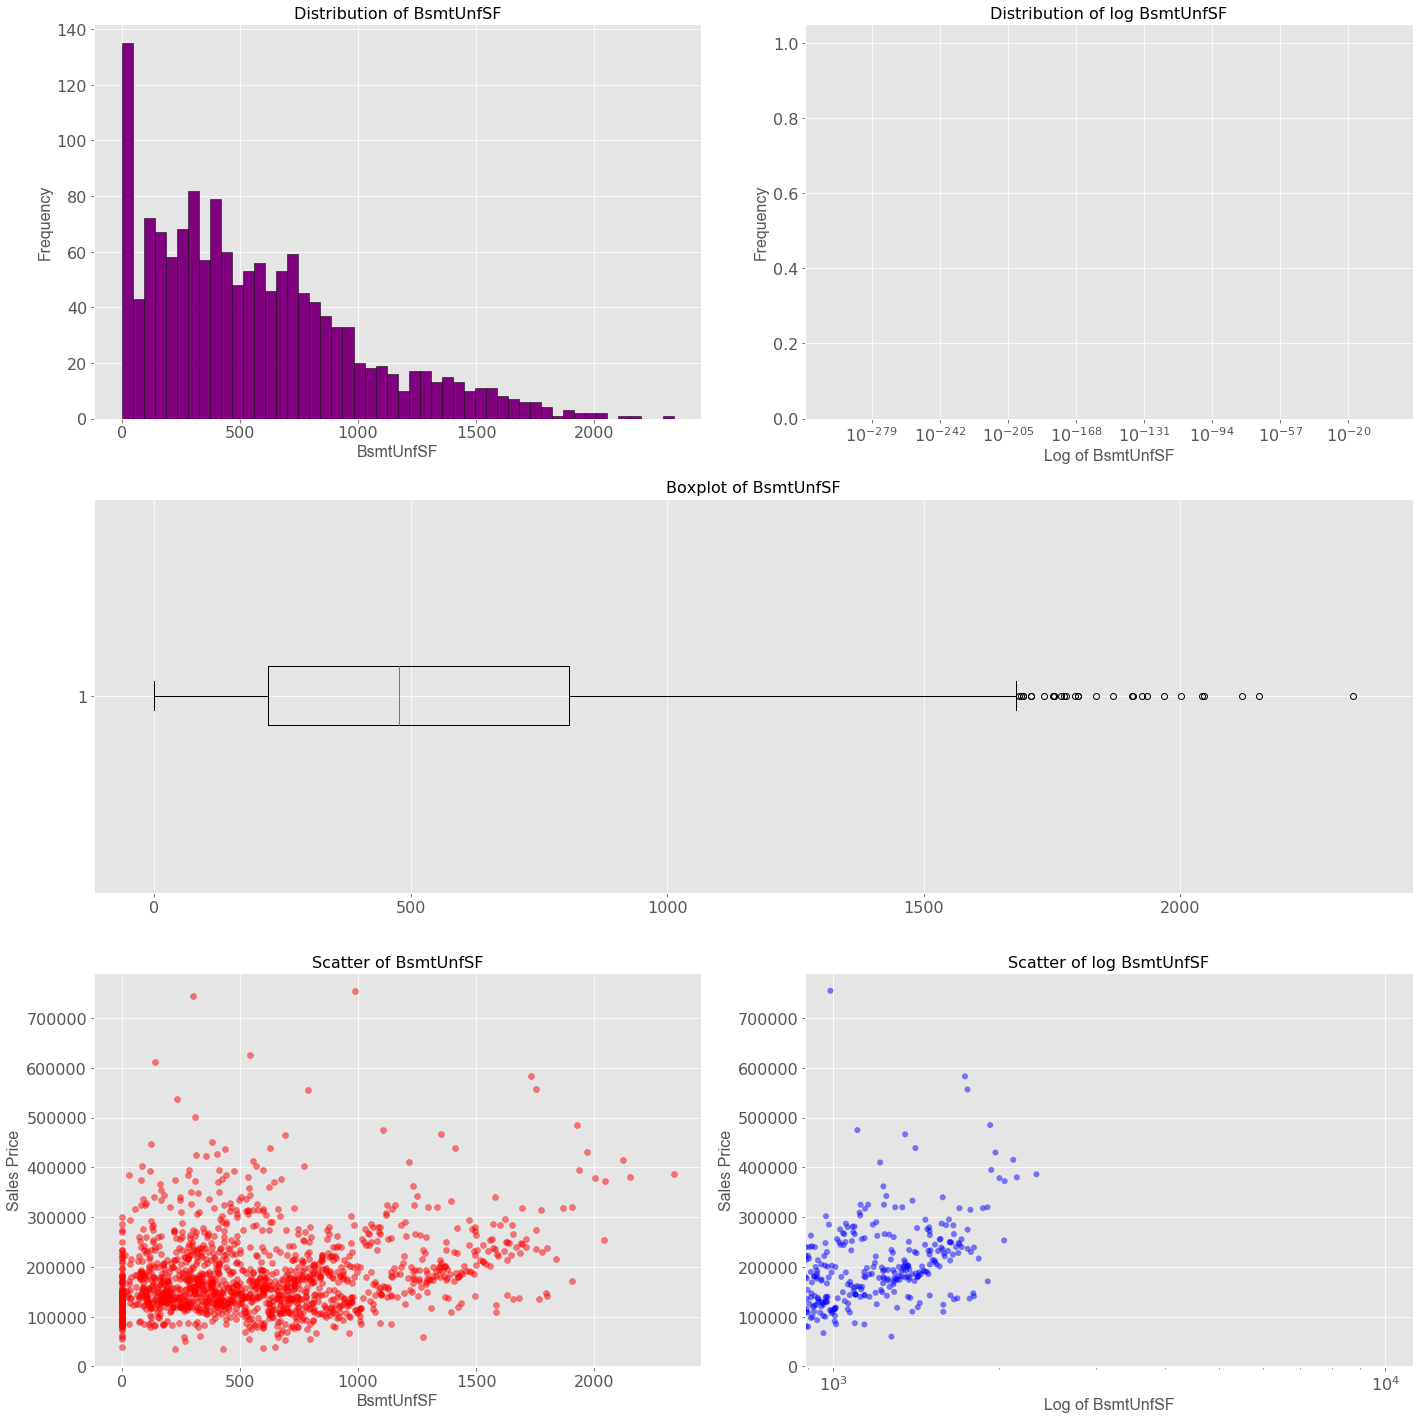

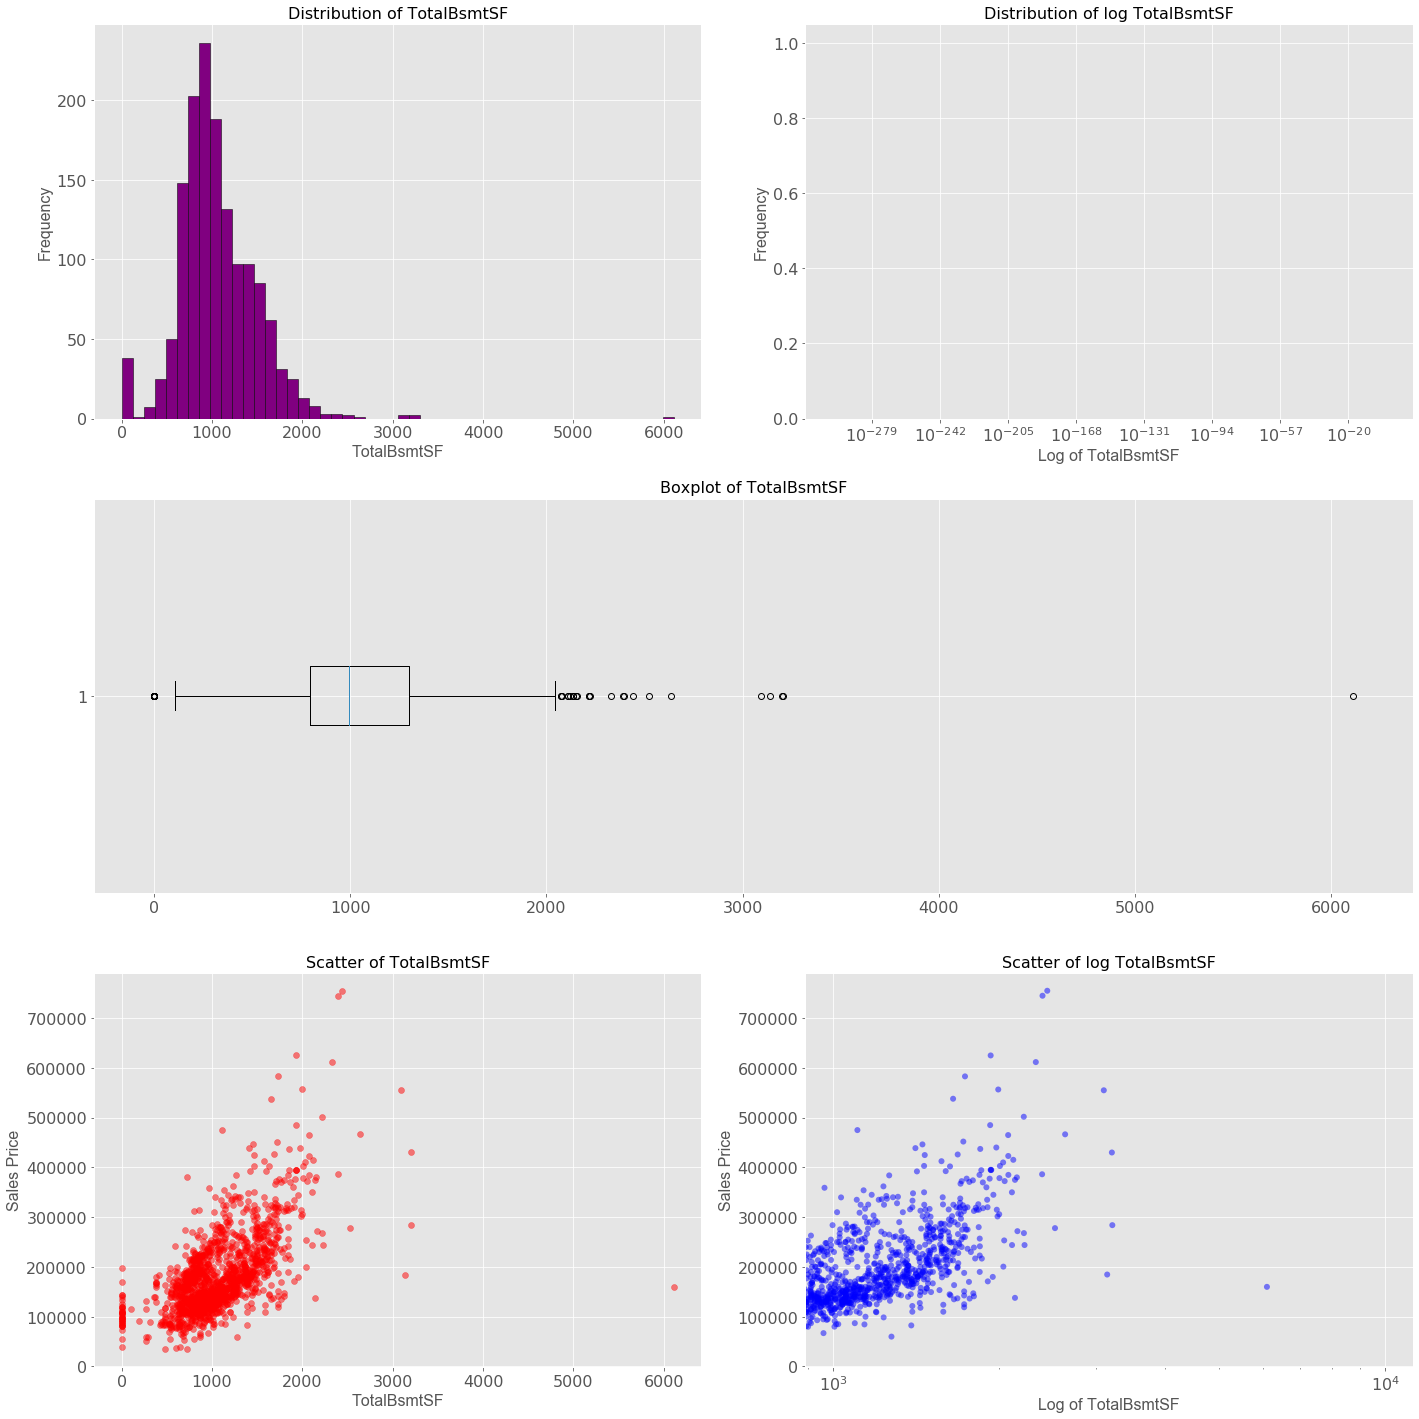

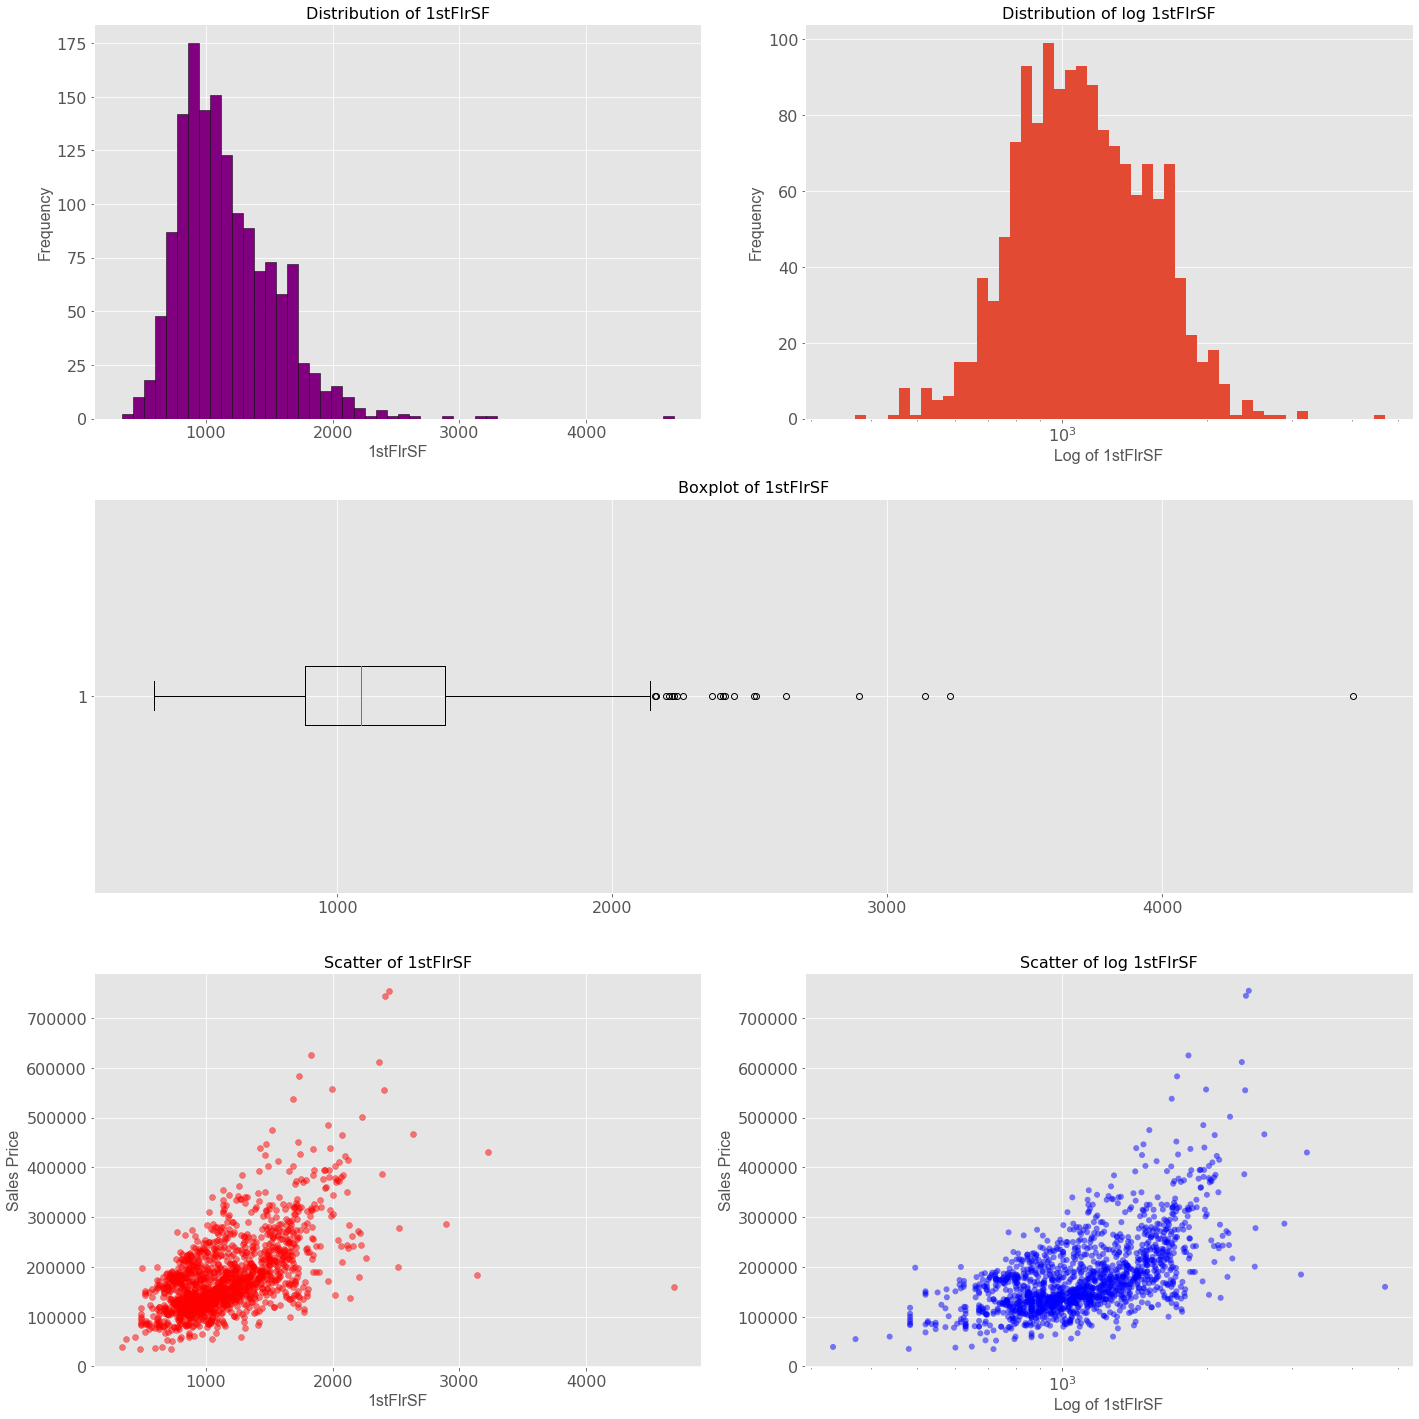

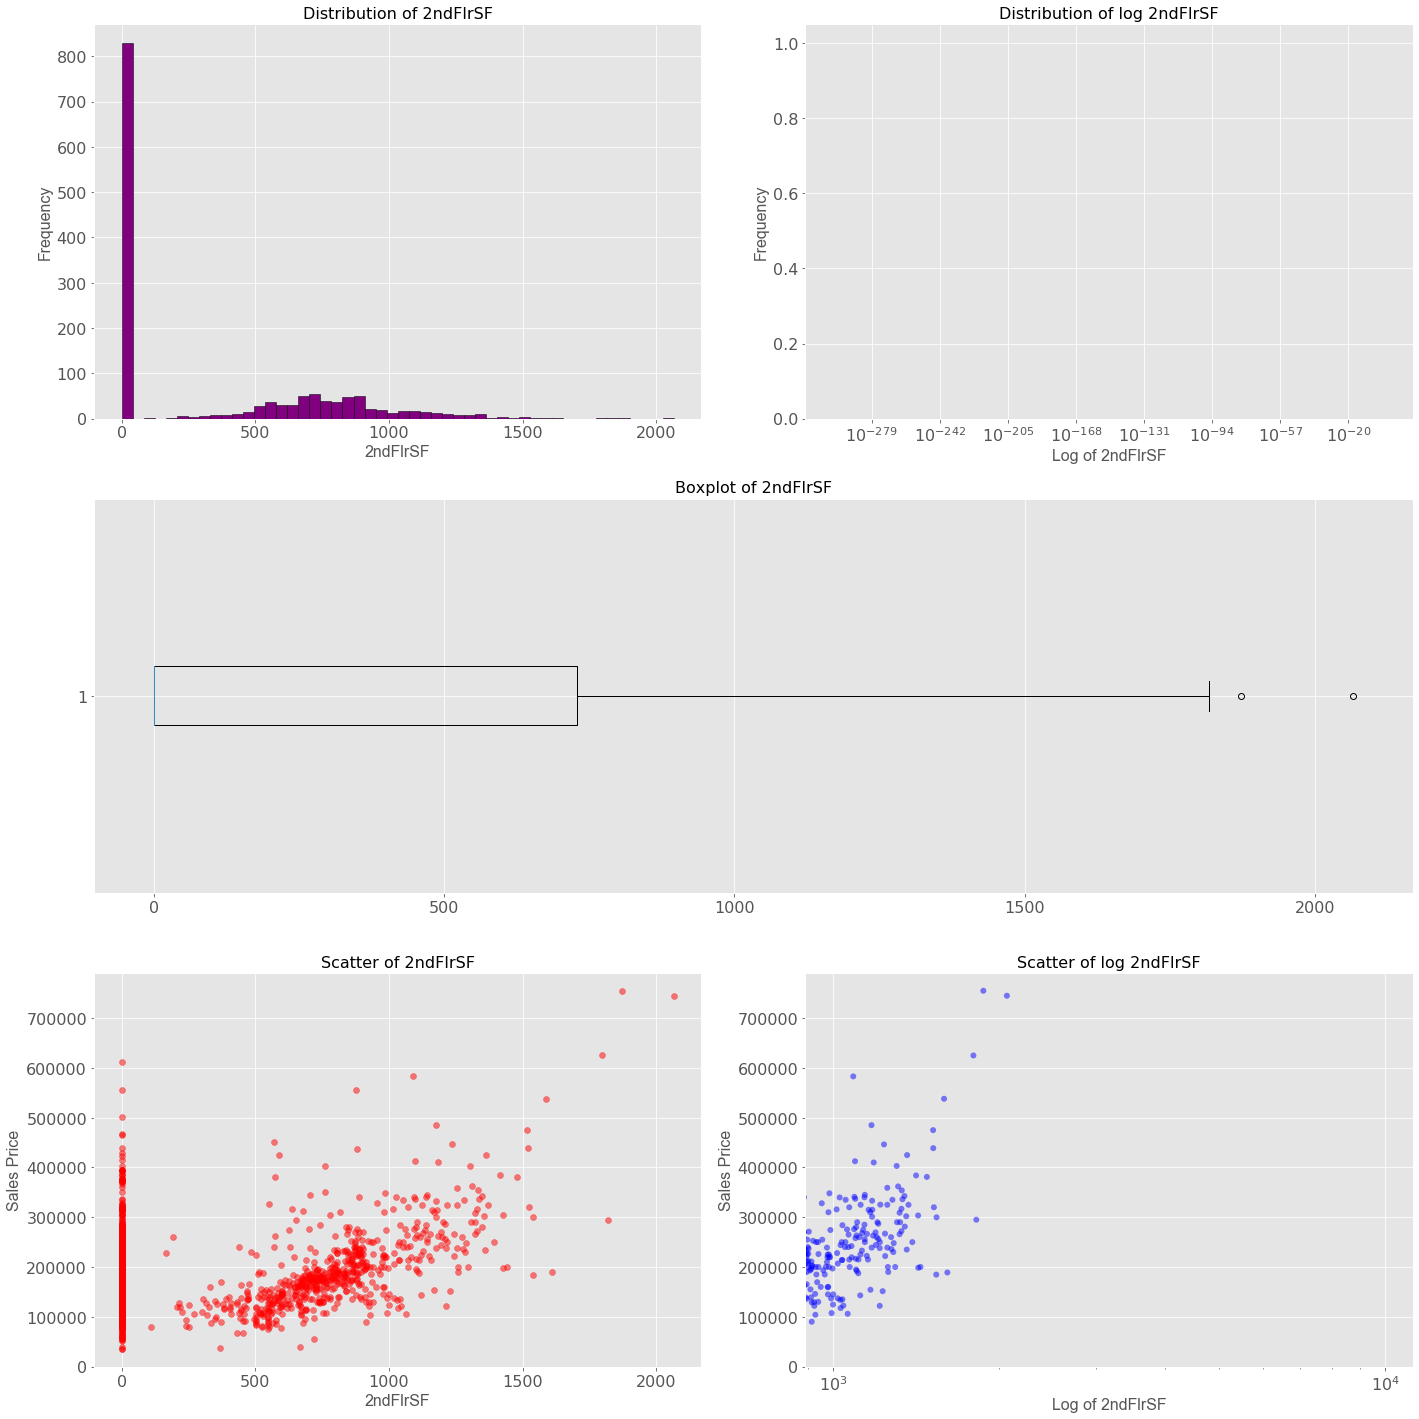

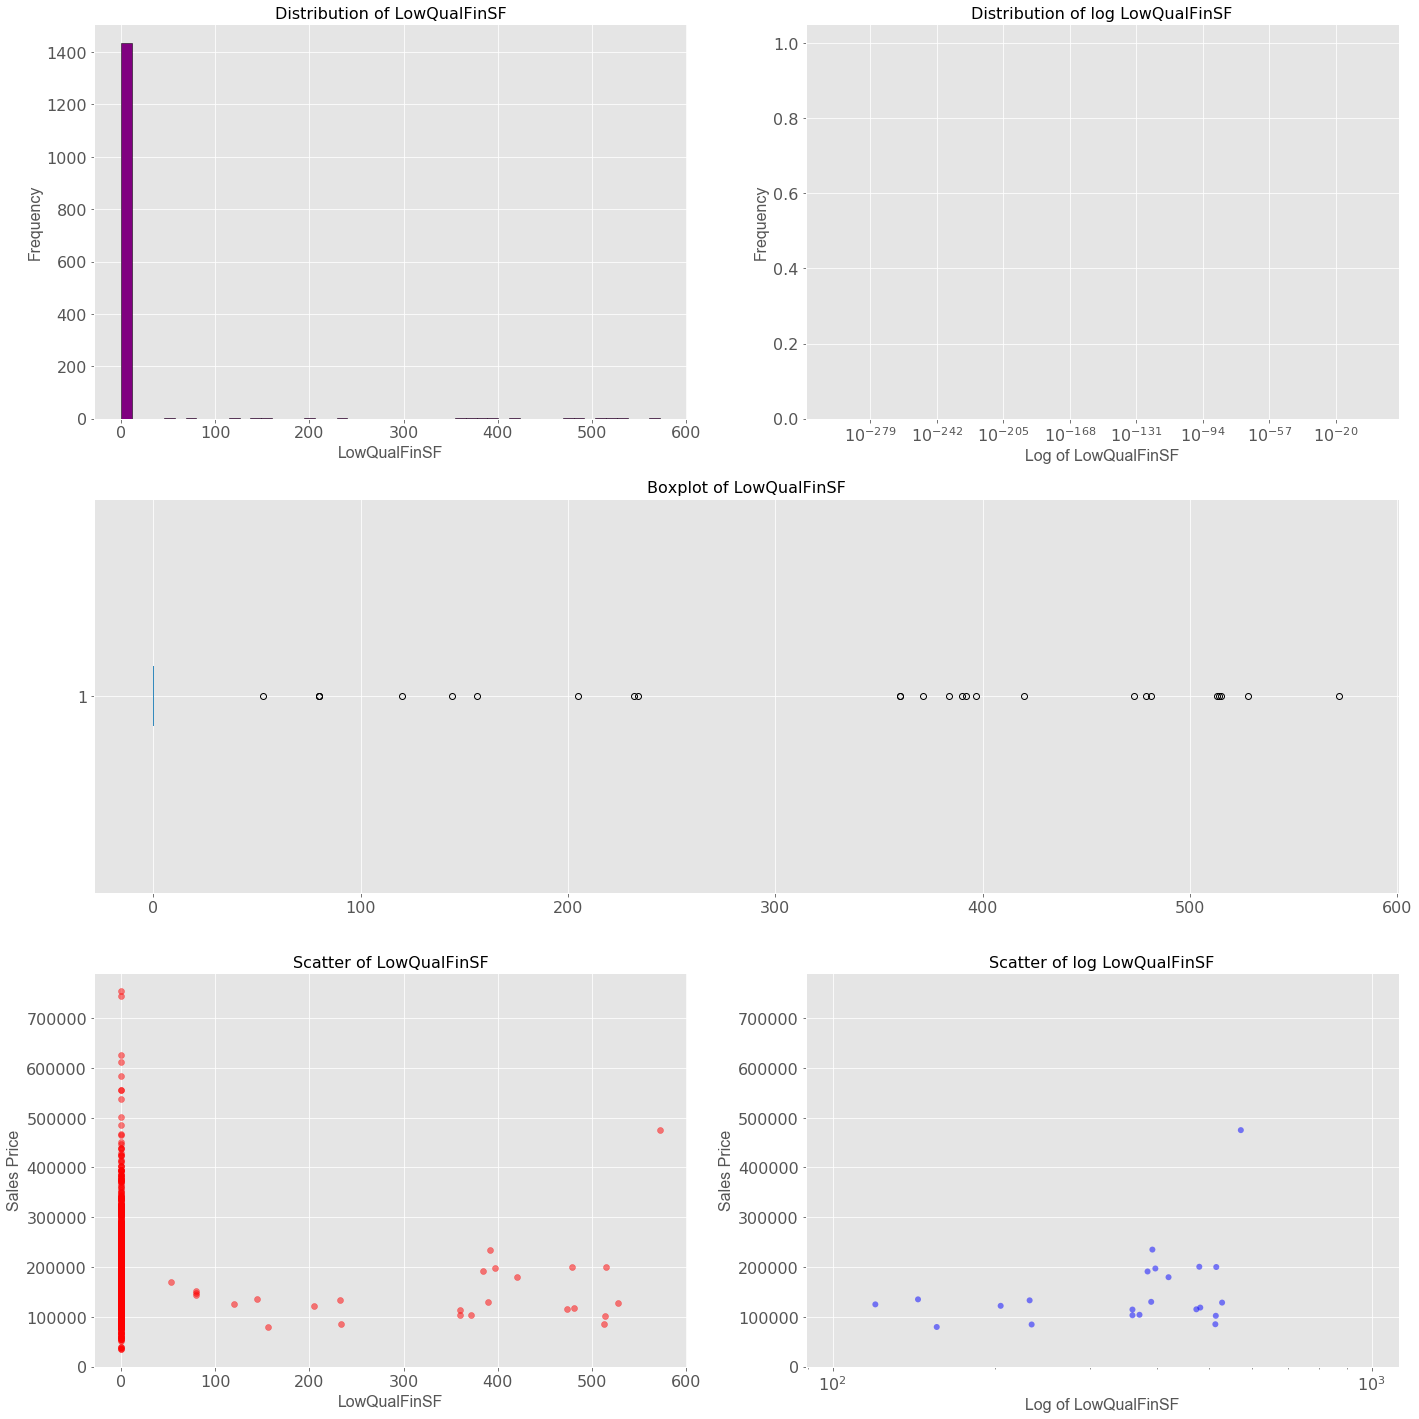

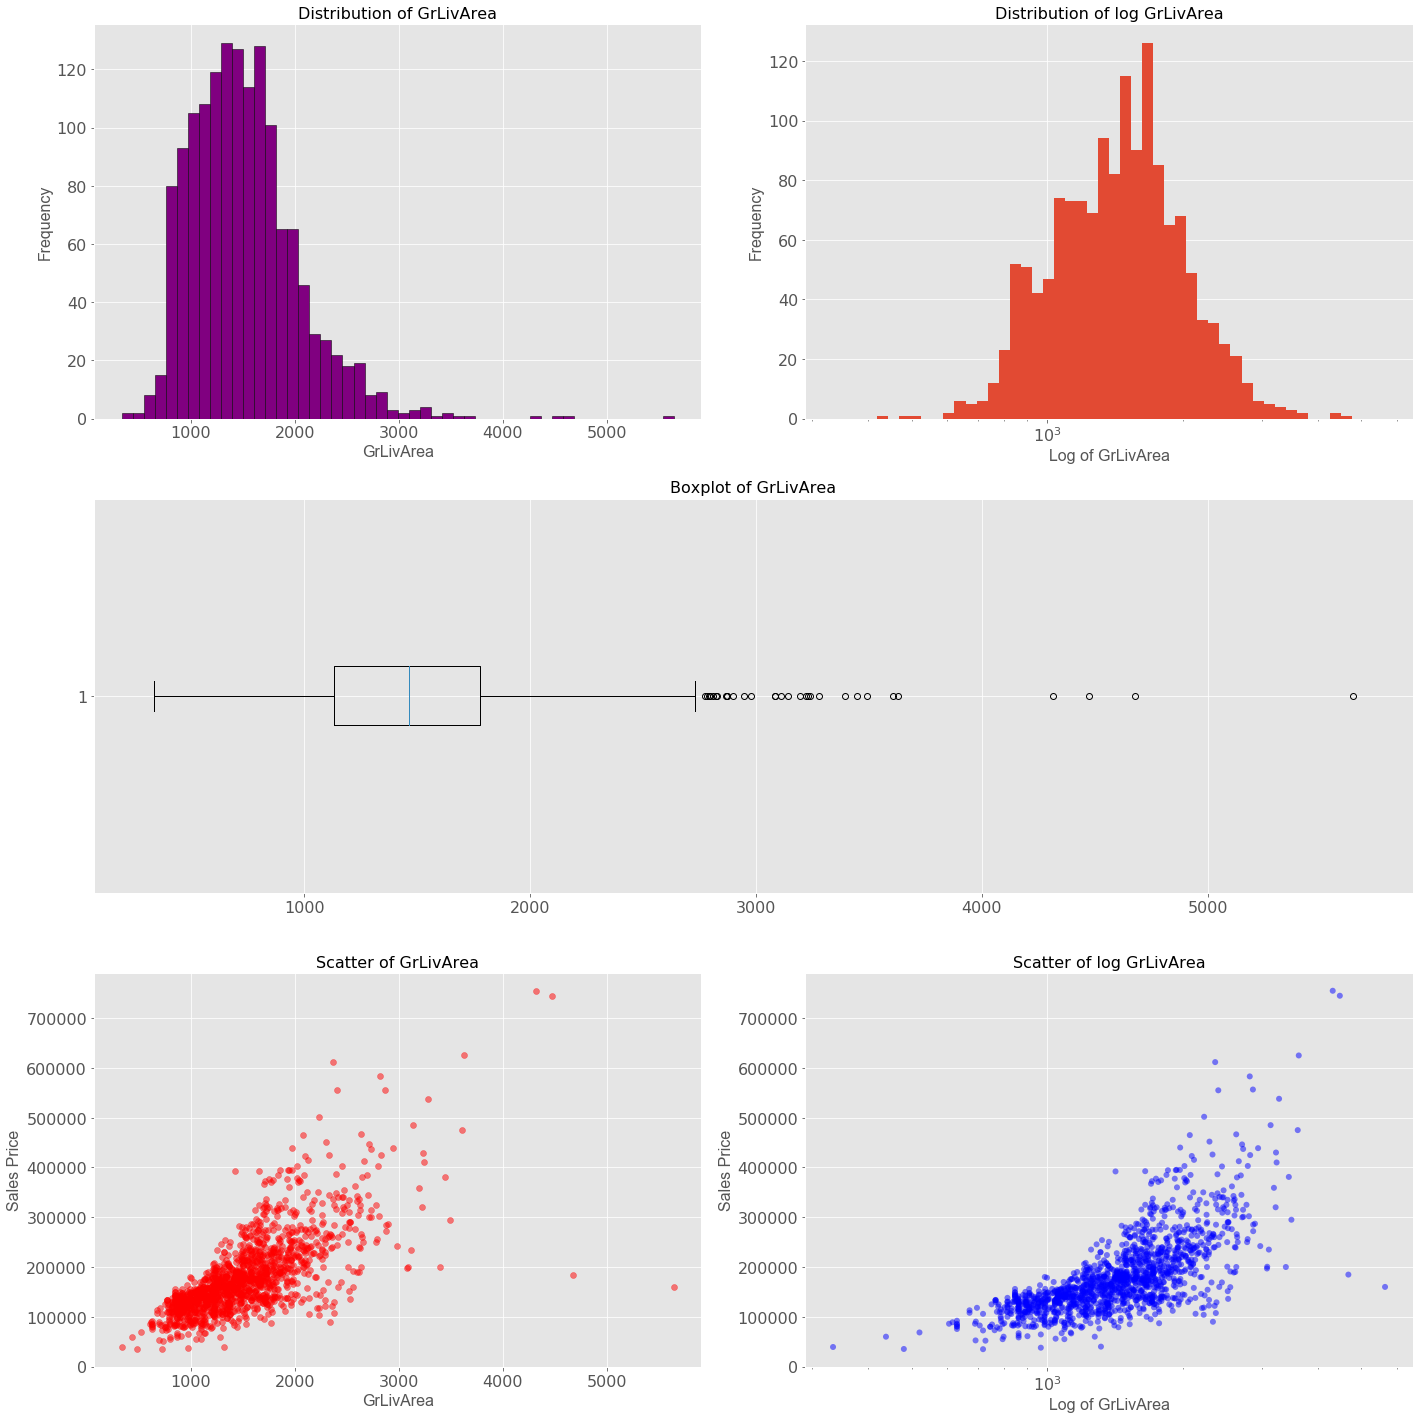

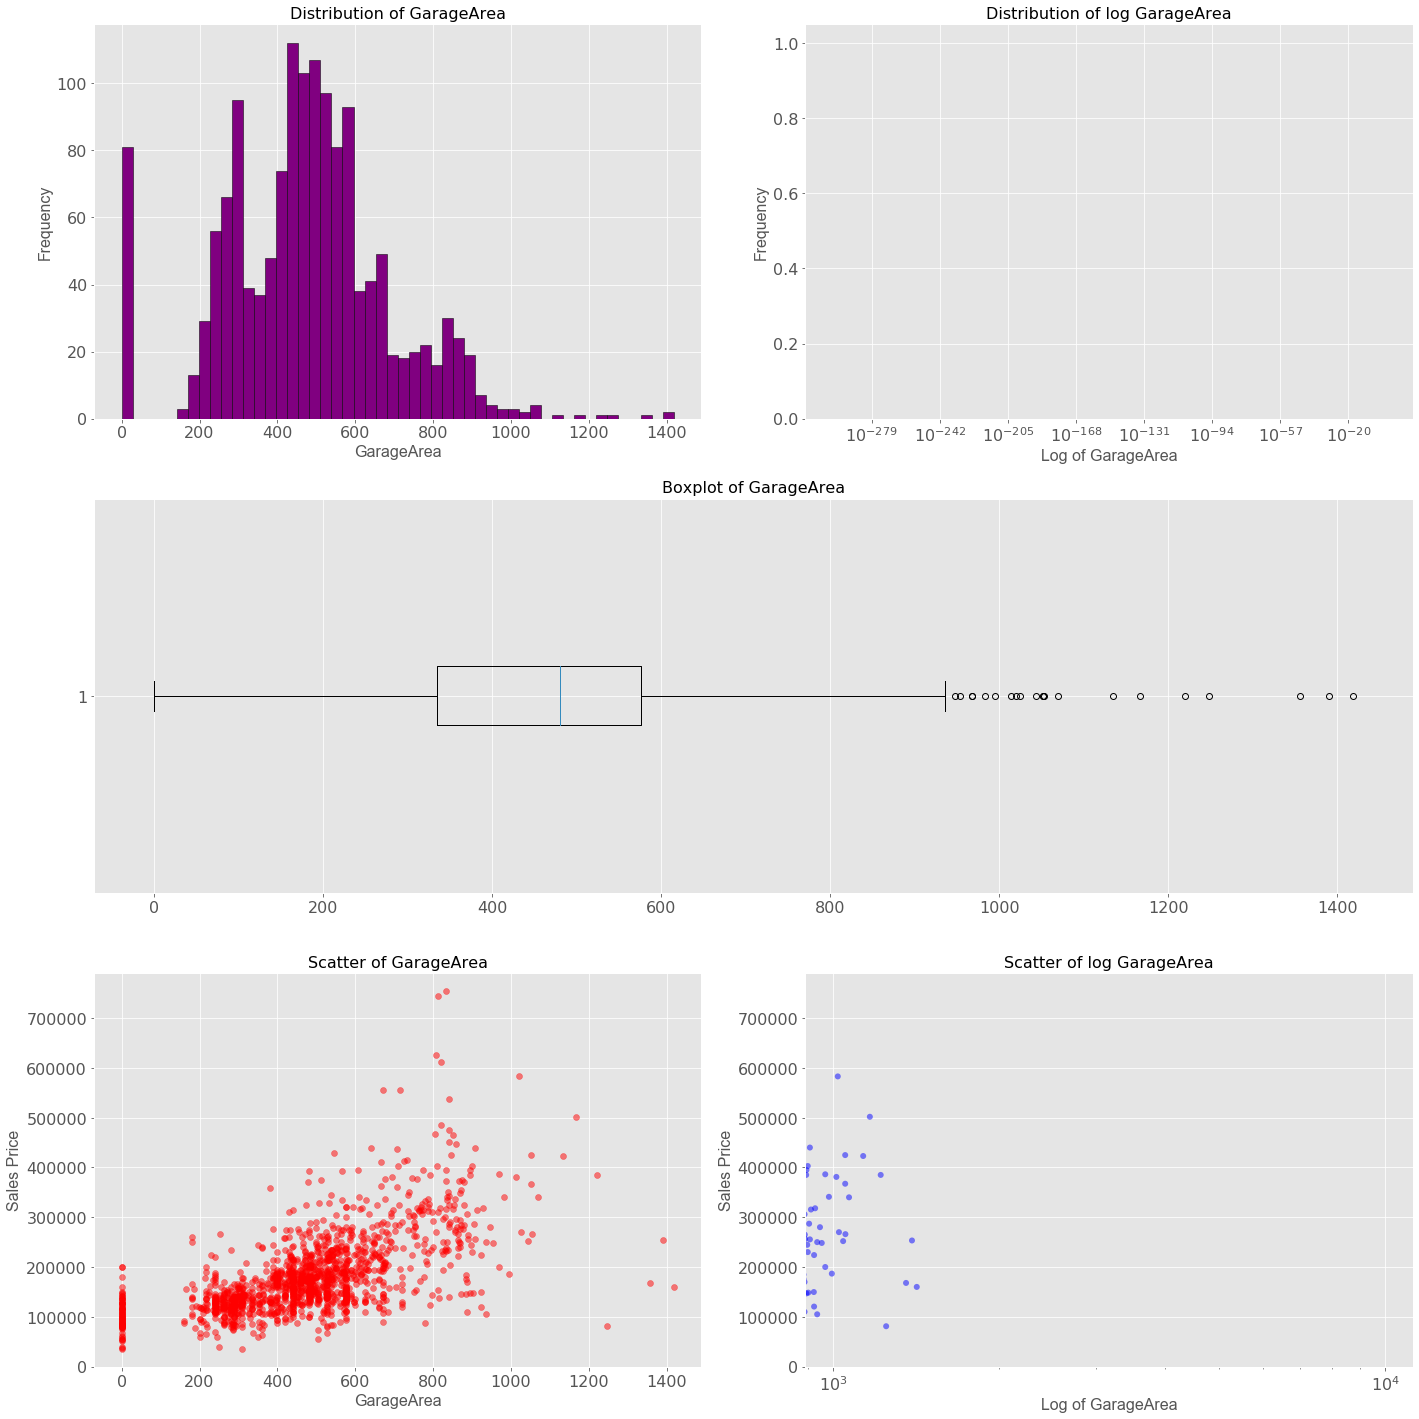

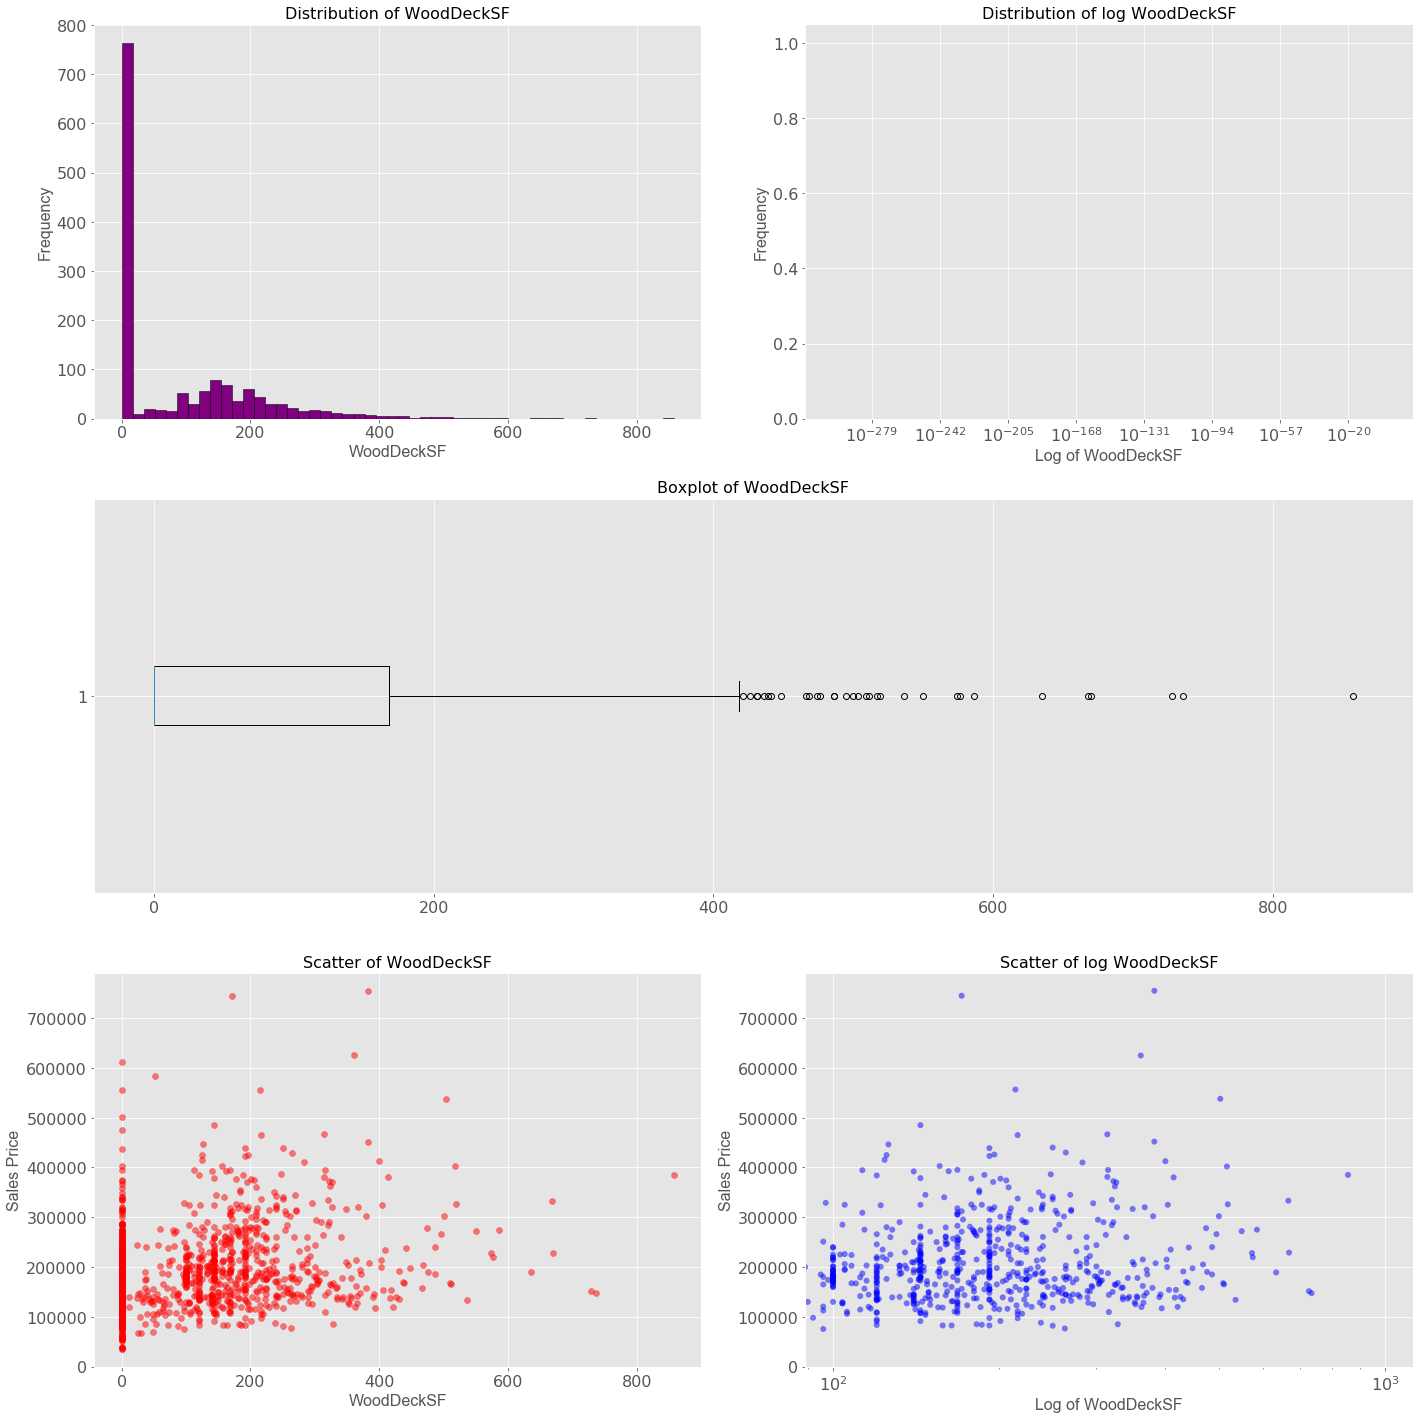

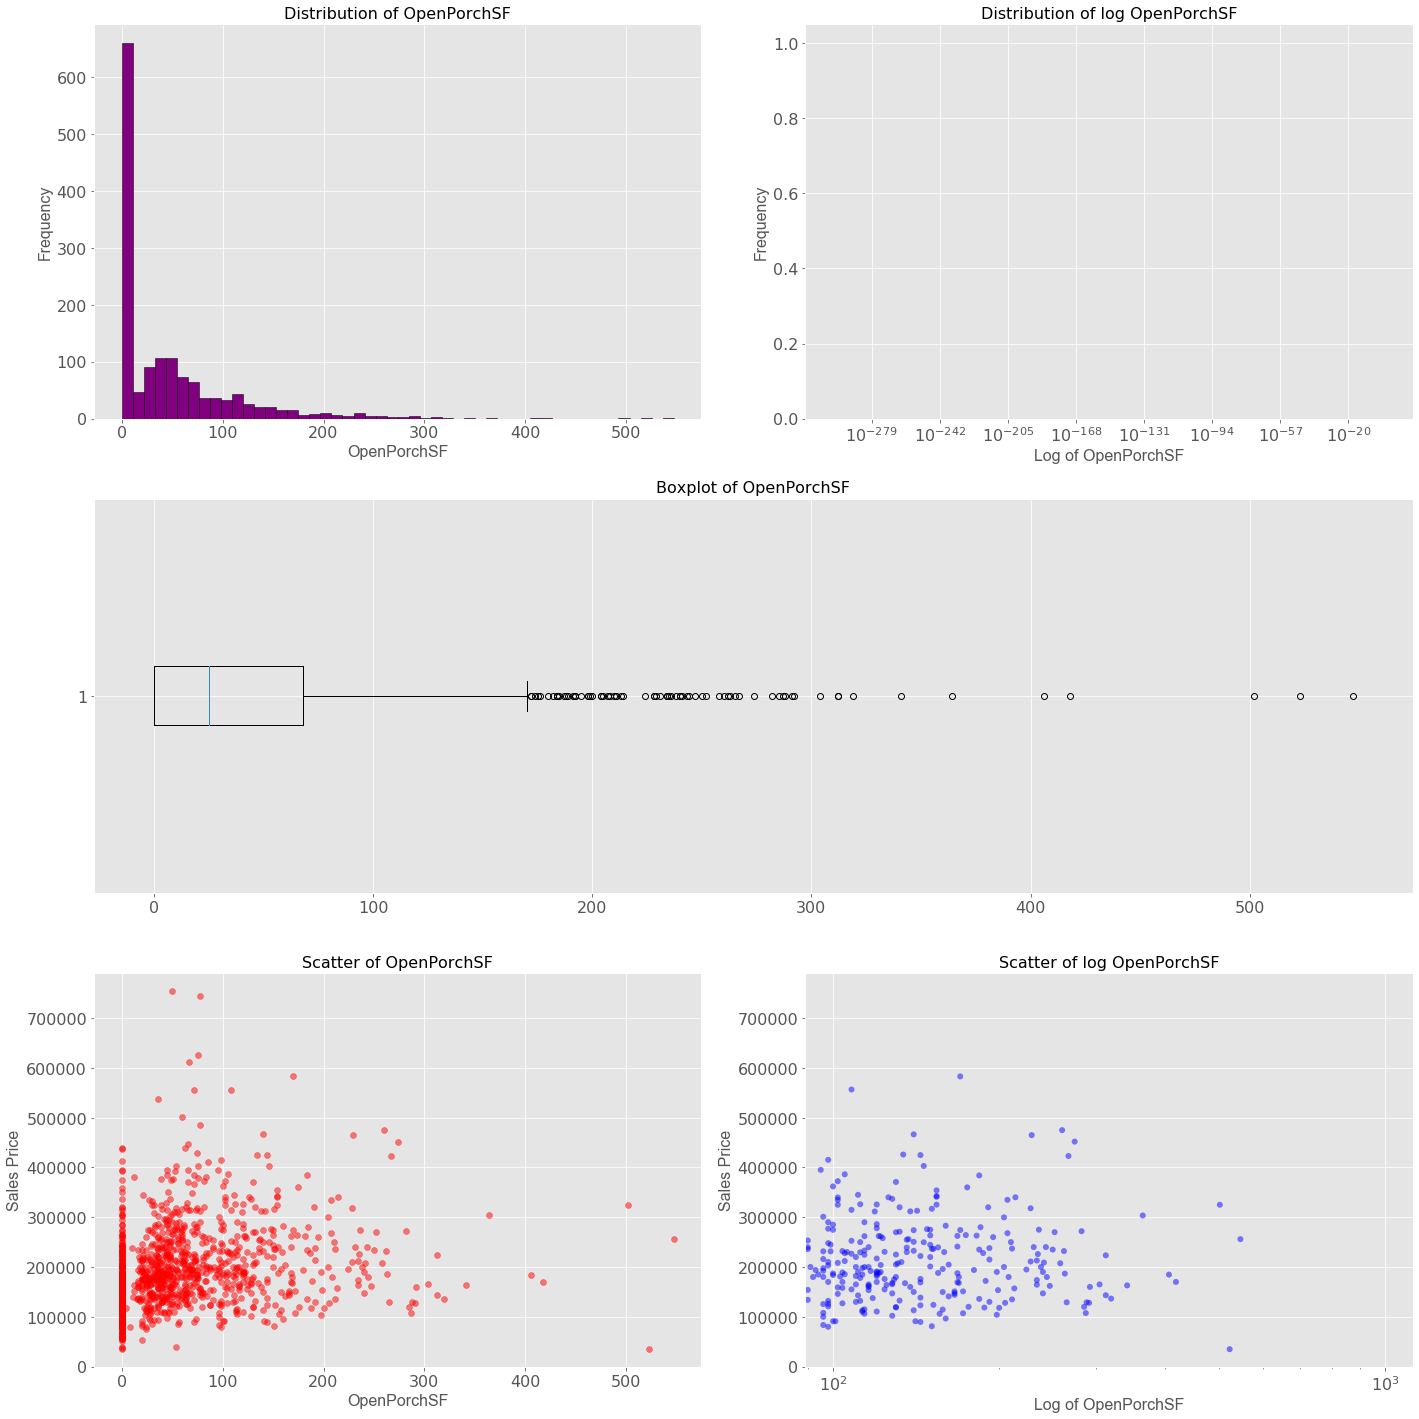

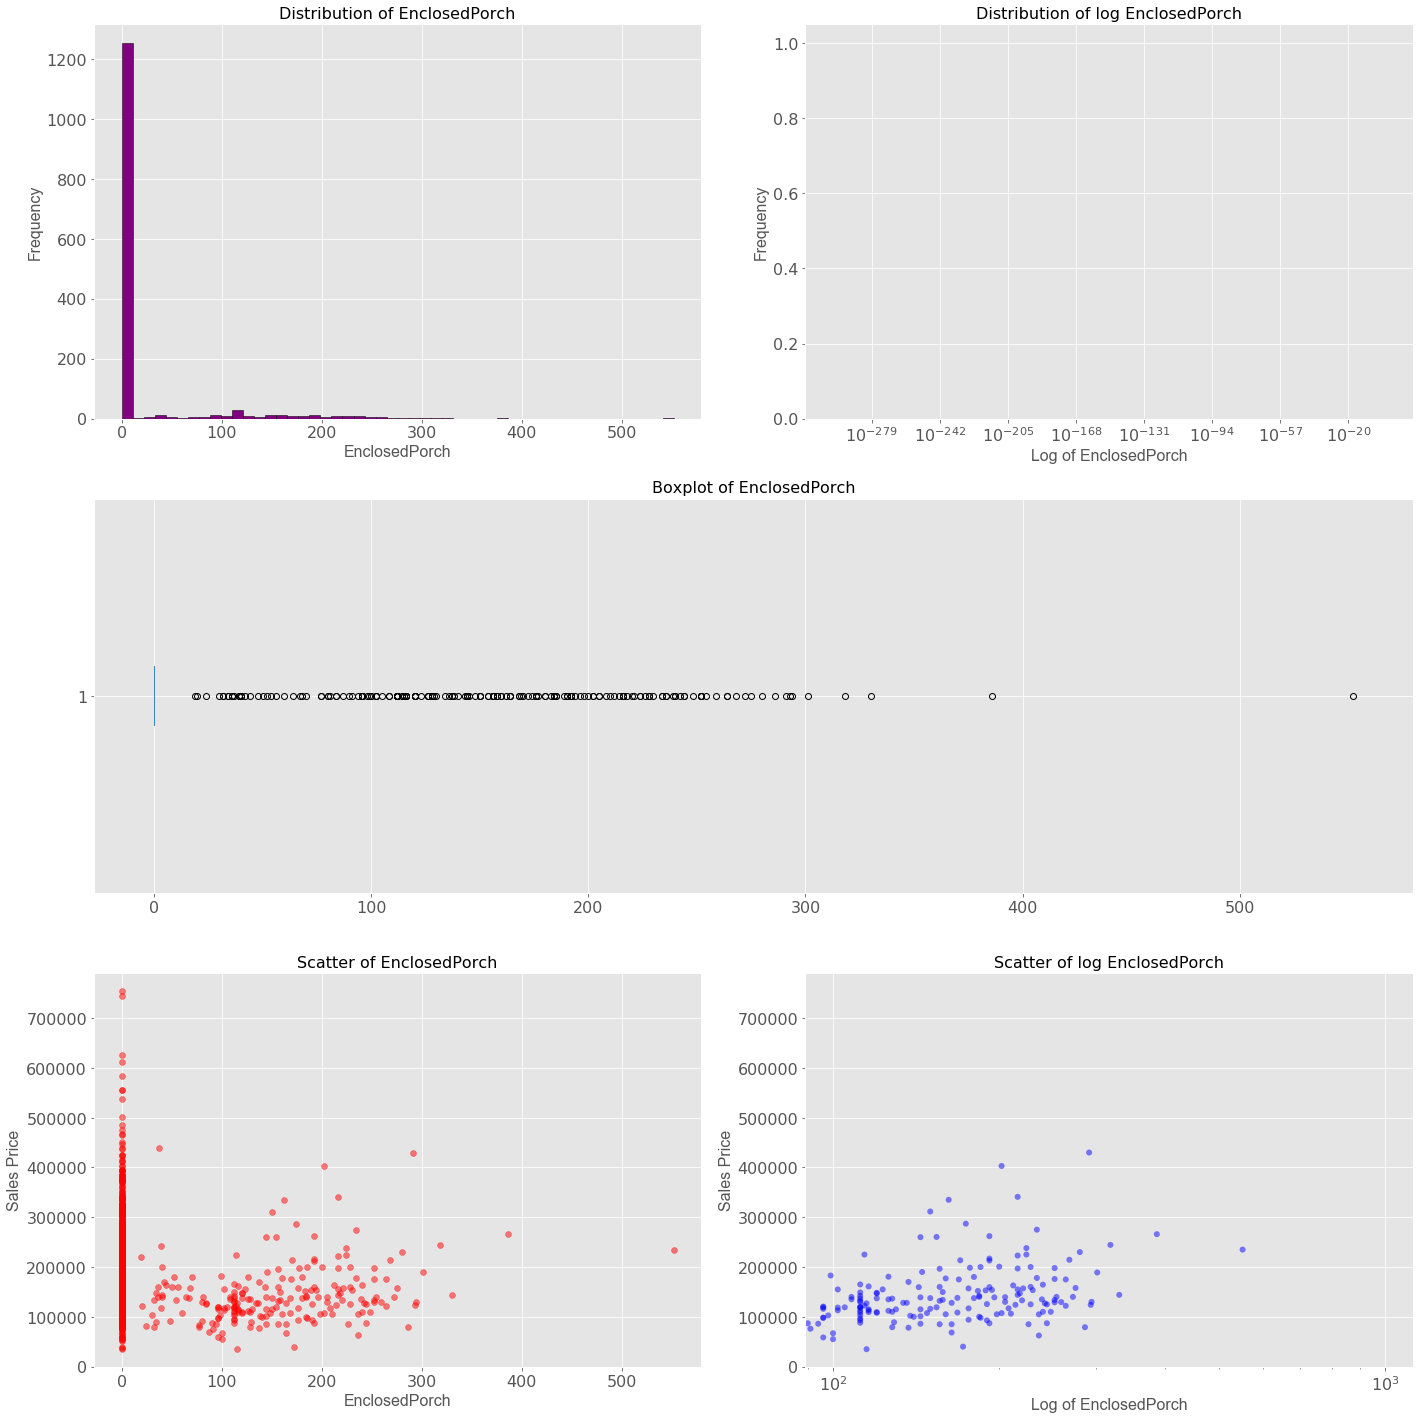

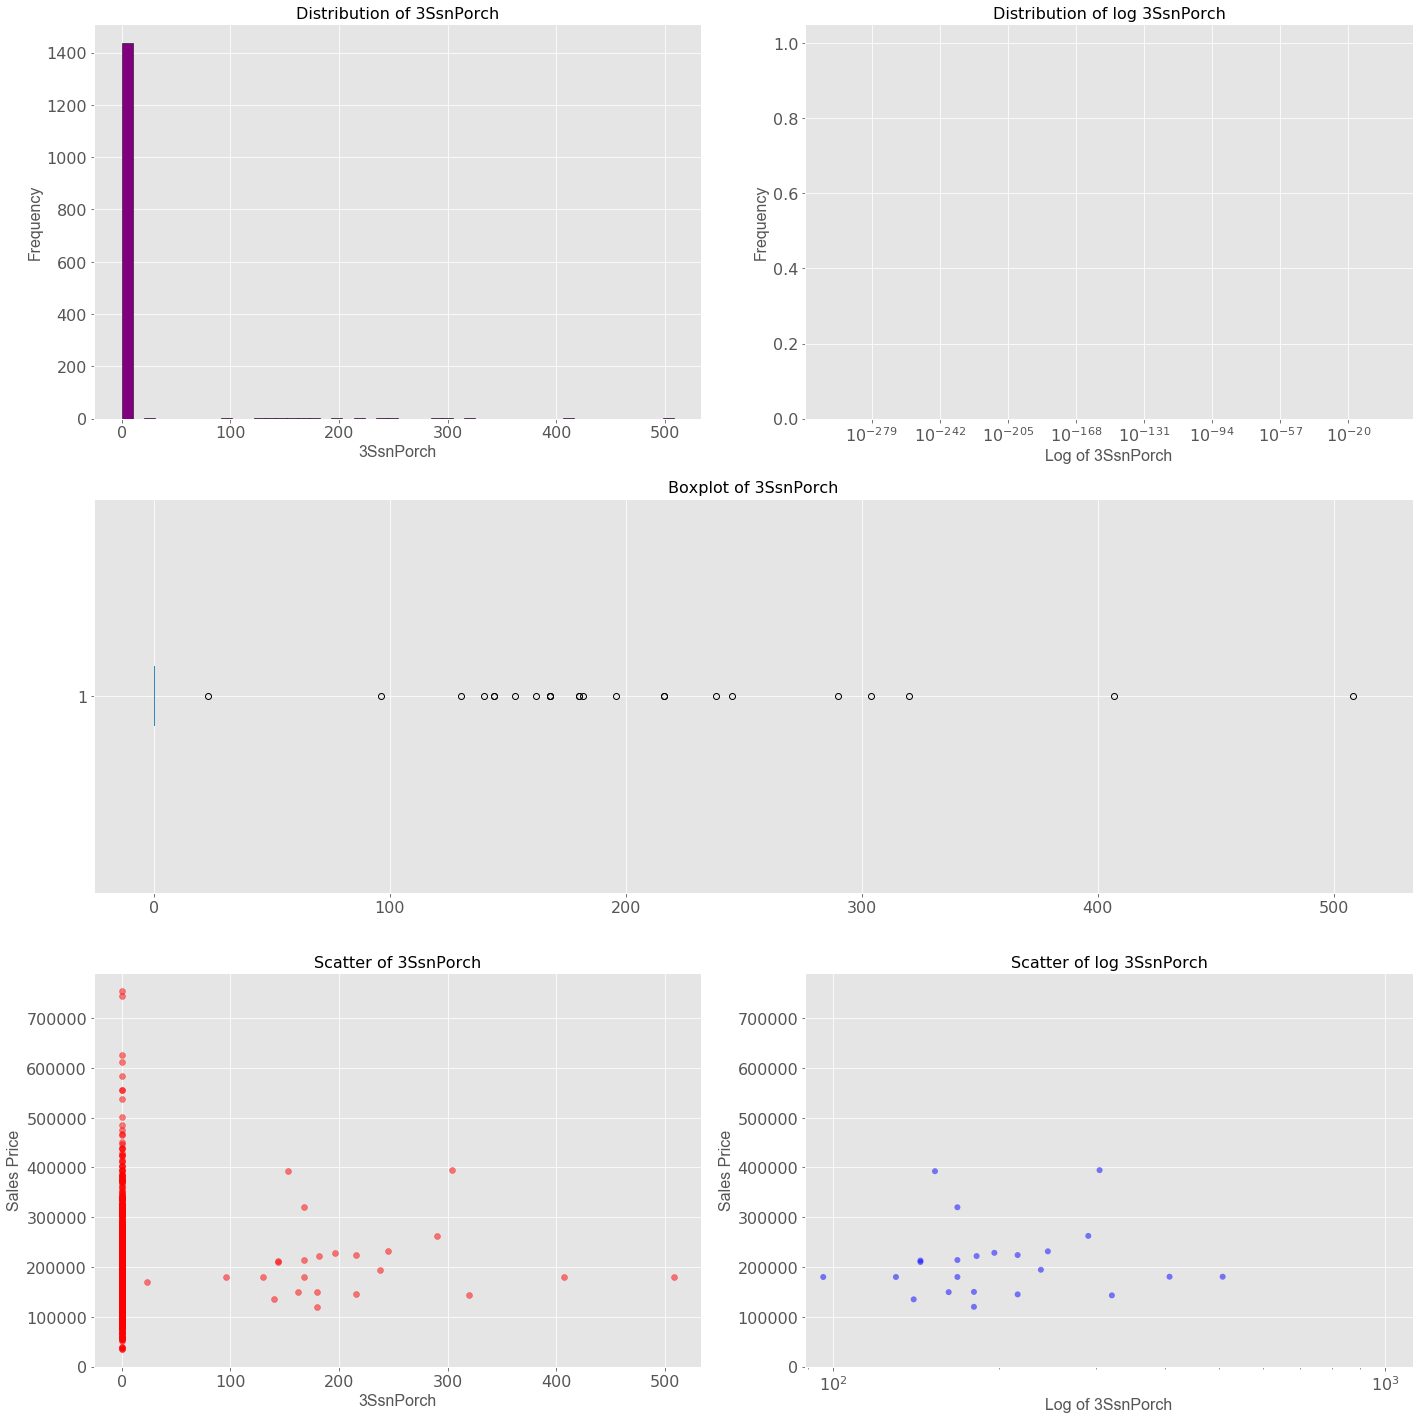

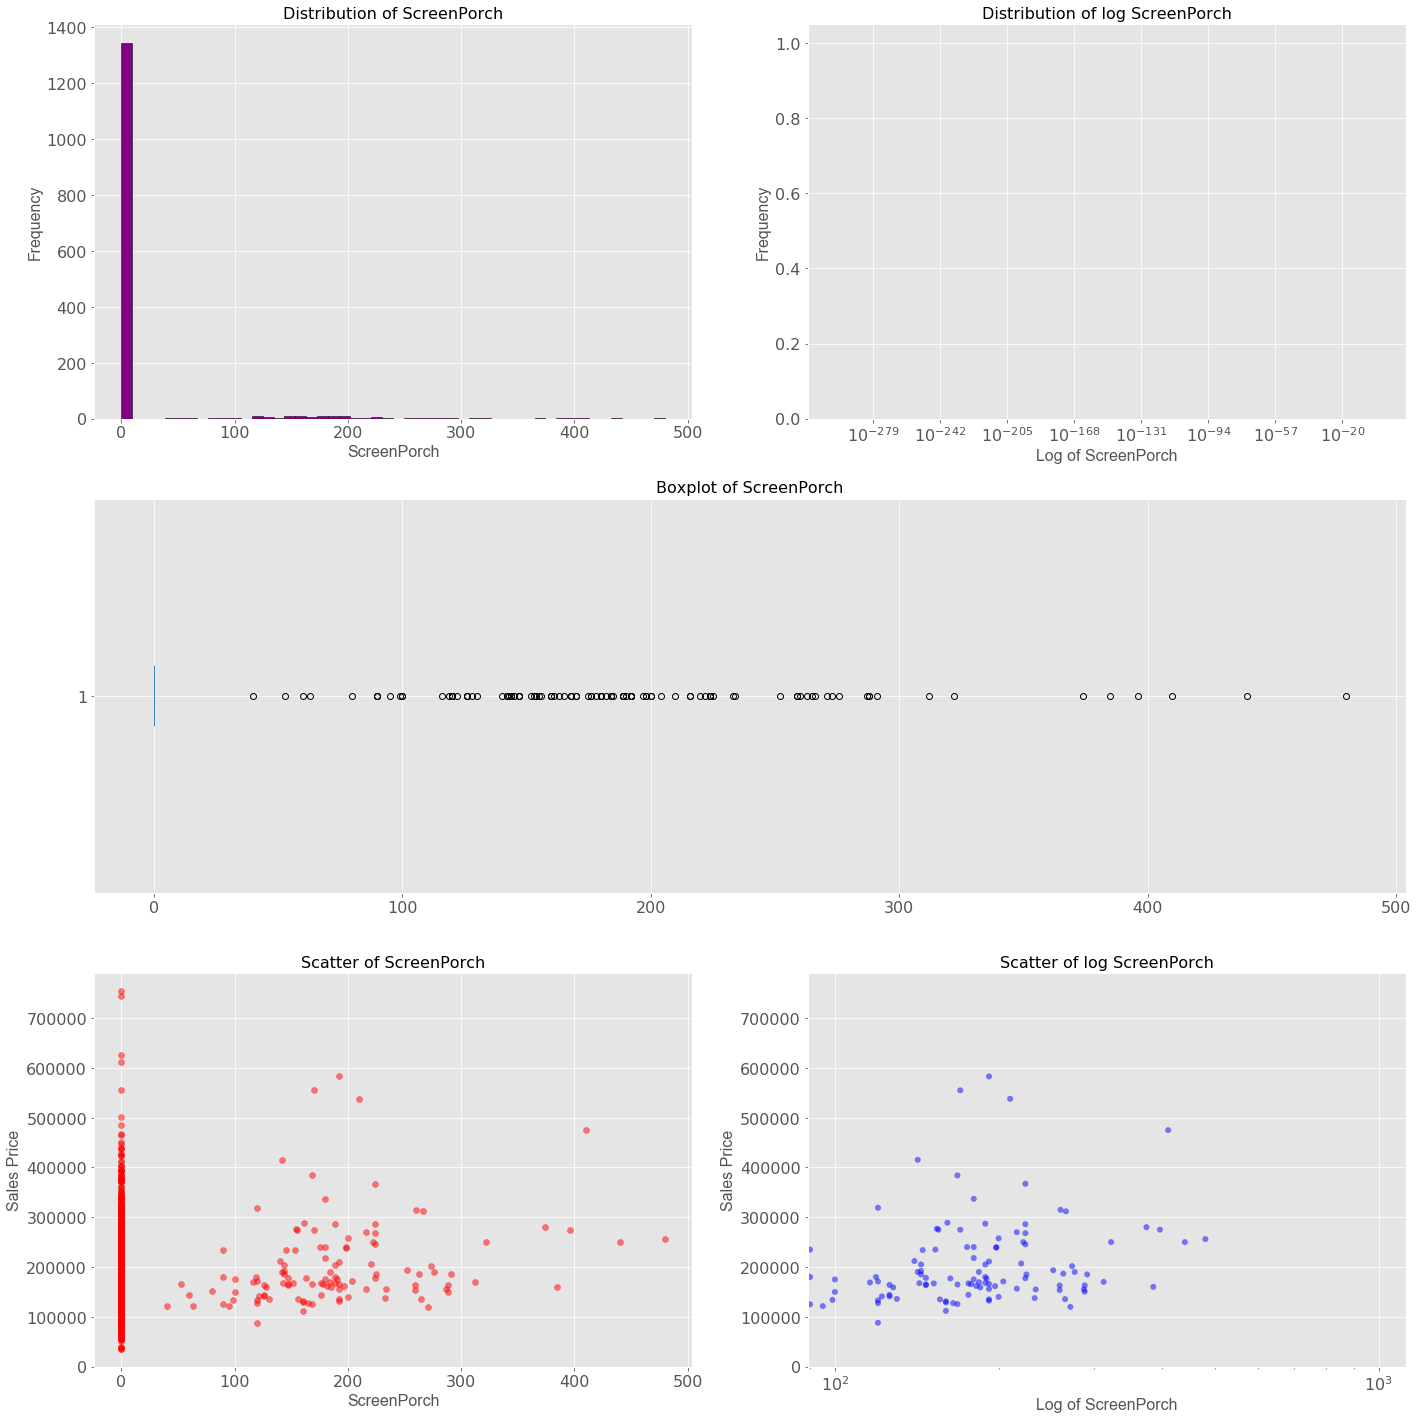

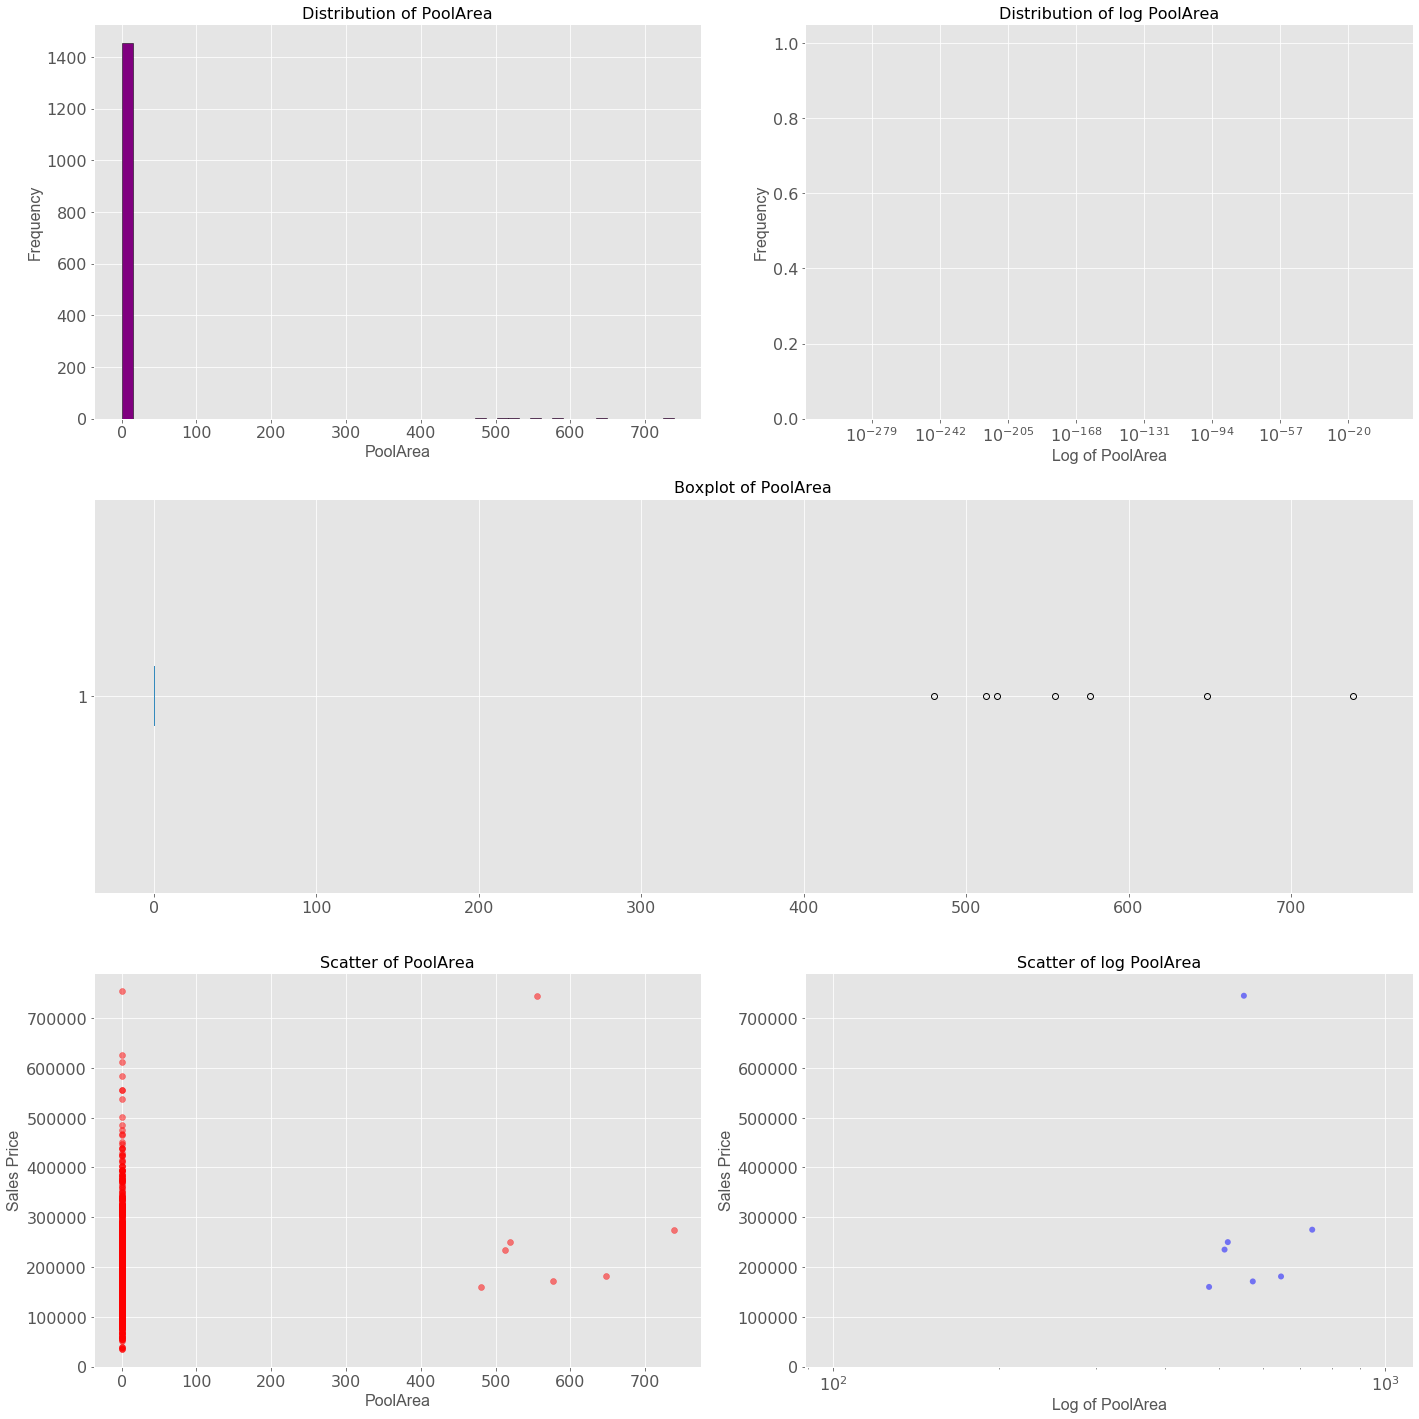

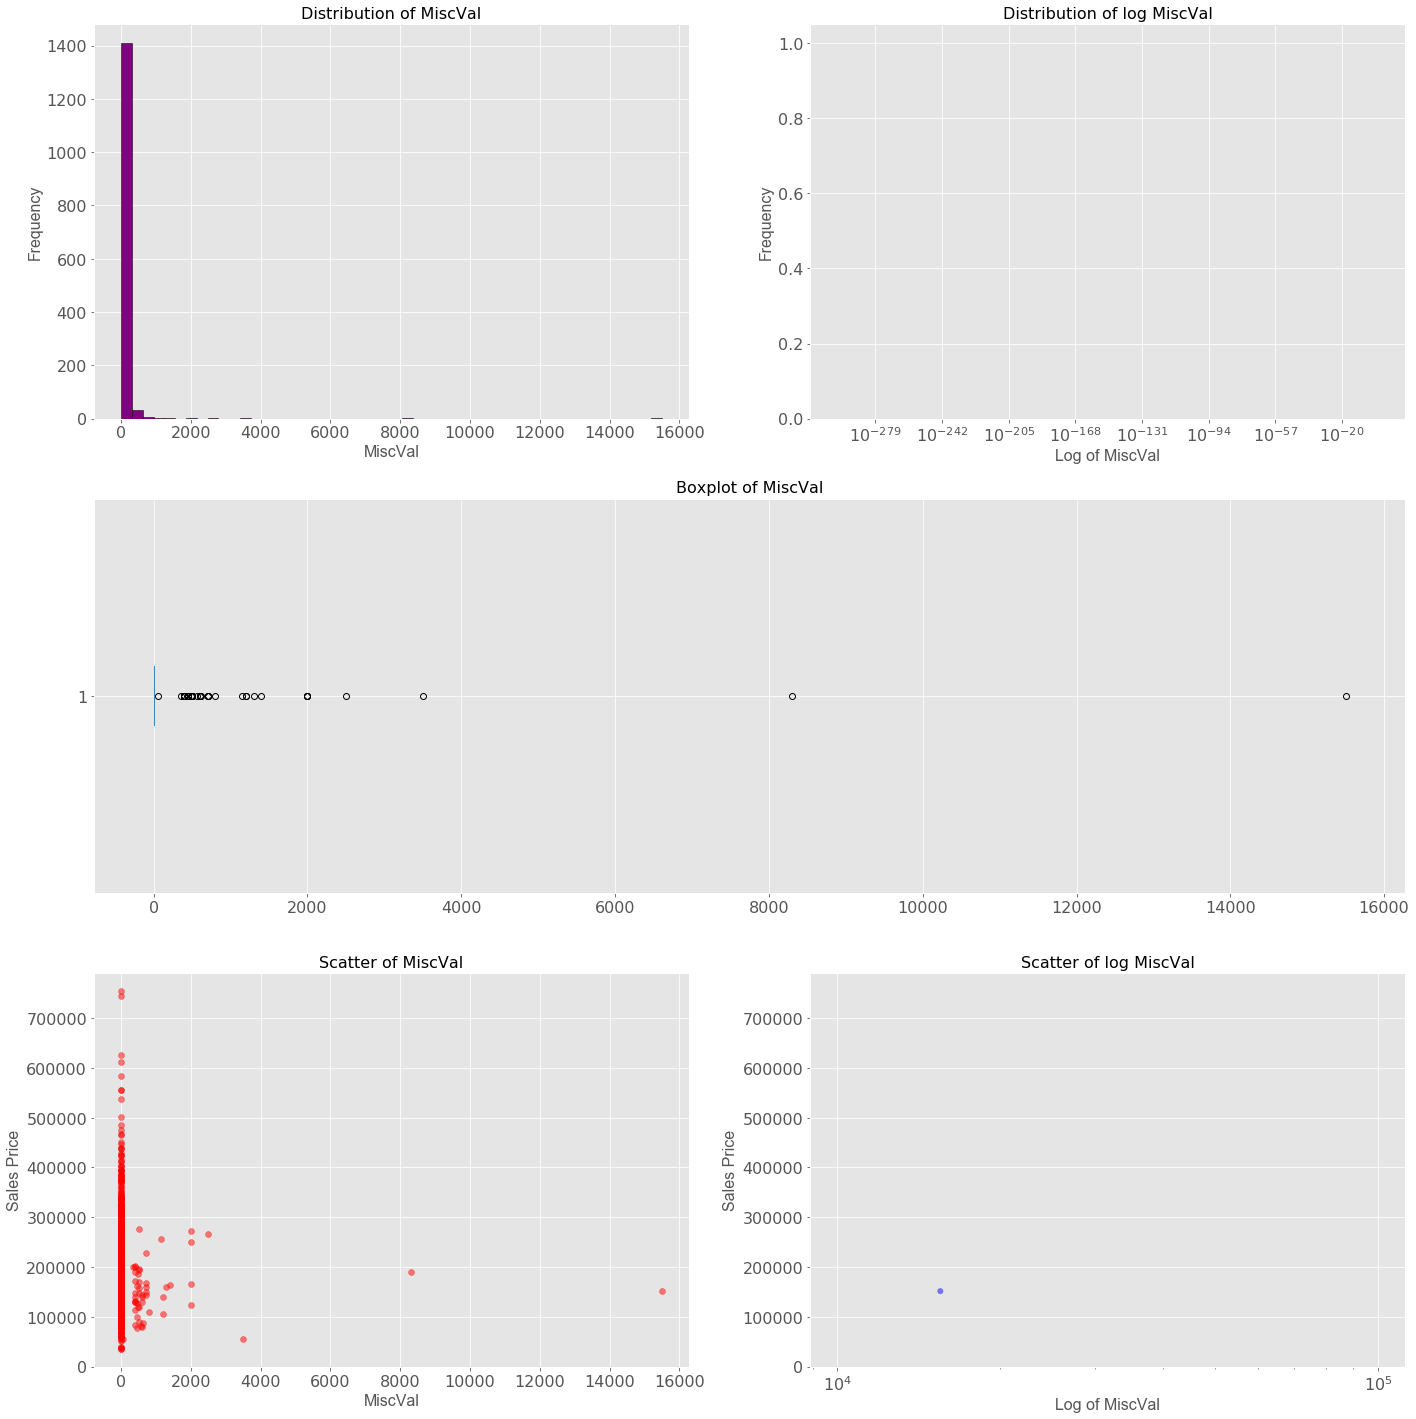

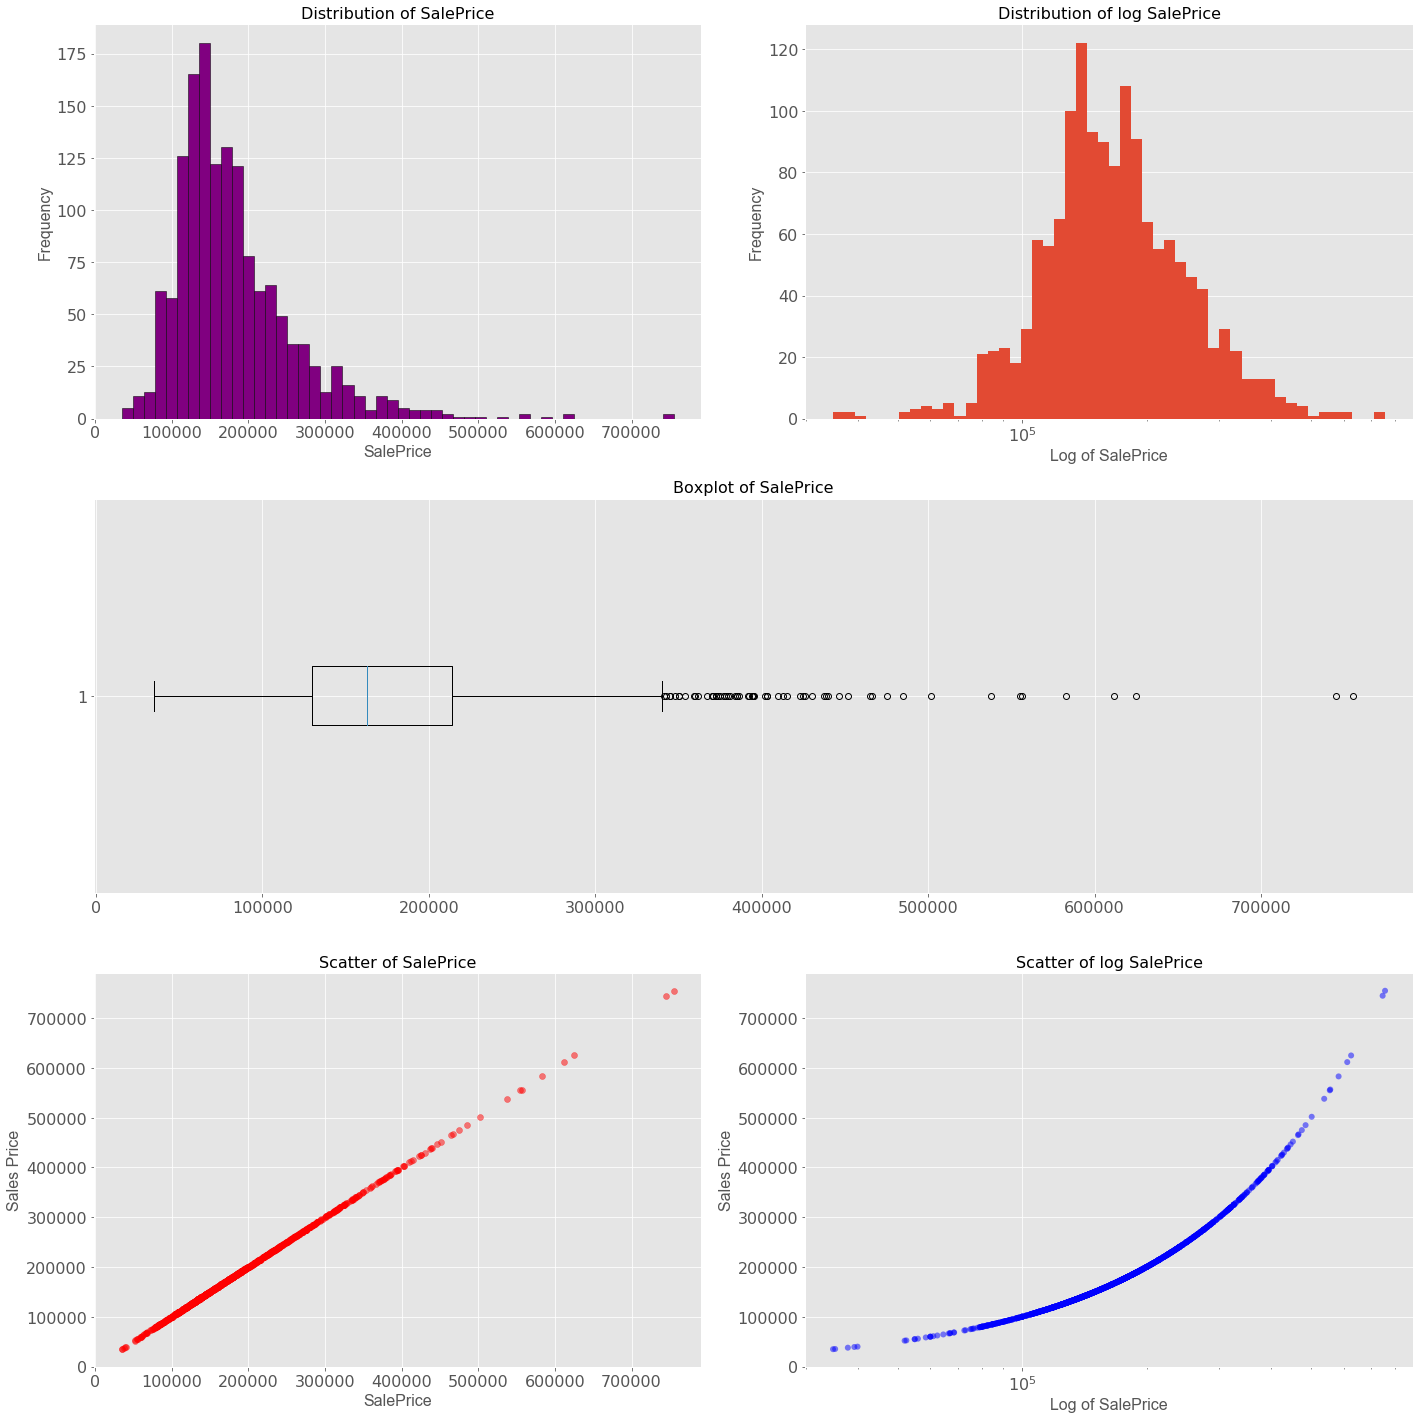

In [205]:
# lets look at histogram of all numeric variables
out_pdf = r'C:\Users\saleh\Desktop\House Prices\num_vars.pdf'
pdf = matplotlib.backends.backend_pdf.PdfPages(out_pdf)

plt.style.use('ggplot')

axis_font = {'fontname':'Arial', 'size':'16'} # set axes title font and style
vars = list(data_num.columns)

# plt.figure(figsize=(15,8)) # create new figure
plt.rcParams.update({'font.size': 16}) # set axes values font and style

for var in vars:

    fig, axs = plt.subplots(ncols=2, nrows=3,figsize=(20,20)) # create a 3x2 subplot grid
    gs = axs[1, 1].get_gridspec() 



    plt.subplot(321)
    # # Histogram of the height
    hist, bins, _ = plt.hist(data_num[var],color='purple',edgecolor='black',bins=50)
    plt.title('Distribution of ' + var, size=16)
    plt.xlabel(var, **axis_font)
    plt.ylabel('Frequency', **axis_font)



    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins)) # create log bins for log plot
    plt.subplot(322)
    plt.title('Distribution of log ' + var, size=16)
    plt.hist(data_num[var], bins=logbins)
    plt.xscale('log')
    plt.xlabel('Log of ' + var, **axis_font)
    plt.ylabel('Frequency', **axis_font)


    #remove the underlying axes to combine 2 plots
    for ax in axs[1, 0:]: # remove the axes which is at row 1 and column 0
        ax.remove()
    axbig = fig.add_subplot(gs[1, 0:])

    axbig.boxplot(data_num[var],vert=False)
    plt.title('Boxplot of ' + var, size=16)



    plt.subplot(325)
    plt.scatter(data_num[var],data_num.SalePrice, c='red', alpha = 0.5)
    plt.title('Scatter of ' + var, size=16)
    plt.xlabel(var, **axis_font)
    plt.ylabel('Sales Price', **axis_font)

    plt.subplot(326)
    ax = plt.gca()
    ax.scatter(data_num[var],data_num.SalePrice , c='blue', alpha = 0.5, edgecolors='none')
    ax.set_xscale('log')
    plt.title('Scatter of log ' + var, size=16)
    plt.xlabel('Log of ' + var, **axis_font)
    plt.ylabel('Sales Price', **axis_font)


    plt.tight_layout()

    pdf.savefig(fig)
    plt.close(fig)
    
pdf.close()

Select the features who have more than 0.5 absolute correlation with the price

In [615]:
num_cor = pd.concat([data_num,price],axis=1).corr()['SalePrice'].abs()
final_num = list(num_cor[1:-1][num_cor>0.5].index)

print(final_num)
# check if any columns have Nulls

print(data_num[final_num].isnull().sum())

# only keep the features having high correlation with saleprice
data_num = data_num[final_num]



['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea']
OverallQual     0
YearBuilt       0
YearRemodAdd    0
TotalBsmtSF     0
1stFlrSF        0
GrLivArea       0
FullBath        0
TotRmsAbvGrd    0
GarageCars      0
GarageArea      0
dtype: int64


Create a correlation heatmap for the features selected to see if they are correlated with each other

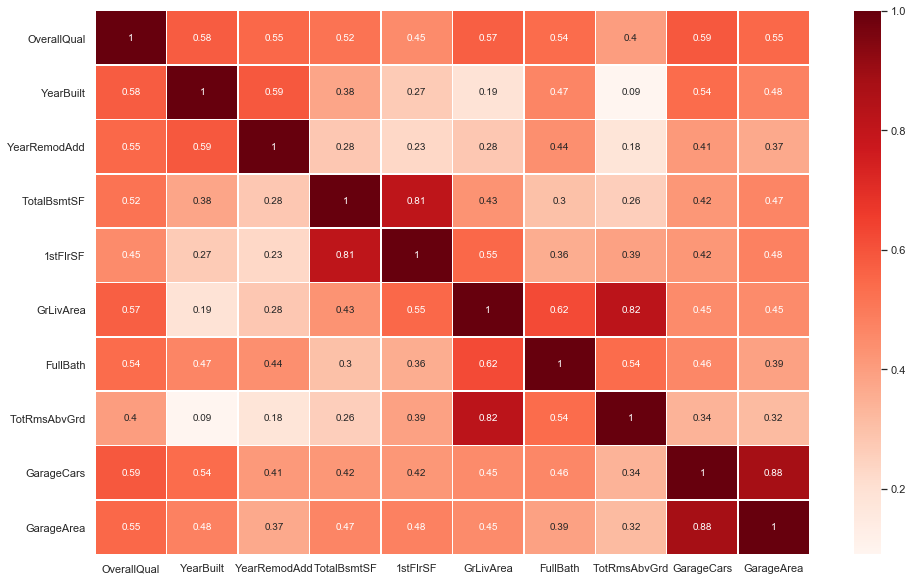

In [616]:
#Using Pearson Correlation
plt.figure(figsize=(16,10))
plt.rcParams.update({'font.size': 10}) # set axes values font and style

cor = round(data_num.corr(),2)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds,linewidths=.5)
plt.show()

Drop the columns TotalBsmtSF, TotRmsAbvGrd, YearRemodAdd, GrLivArea, GarageCars and OverallQual as they have corr higher than 0.5 with other variables

In [617]:
data_num = data_num.drop(('TotalBsmtSF, TotRmsAbvGrd, YearRemodAdd, GrLivArea, GarageCars, OverallQual').split(', '),axis=1)


In [618]:
data_num.describe()

,YearBuilt,1stFlrSF,FullBath,GarageArea
count,1448.000000,1448.000000,1448.000000,1448.000000
mean,1971.080110,1154.845304,1.556630,469.889503
std,30.123527,377.273877,0.543452,211.660605
min,1872.000000,334.000000,0.000000,0.000000
25%,1954.000000,881.500000,1.000000,326.750000
50%,1972.000000,1082.000000,2.000000,478.000000
75%,2000.000000,1381.250000,2.000000,576.000000
max,2010.000000,4692.000000,3.000000,1418.000000


In [619]:
price.describe()

count      1448.000000
mean     177657.070442
std       70678.078392
min       34900.000000
25%      129900.000000
50%      162000.000000
75%      212925.000000
max      465000.000000
Name: SalePrice, dtype: float64

Now run the regression on the numeric features only

In [629]:


X_train, X_test, y_train, y_test = train_test_split(data_num, price, test_size=0.2, random_state=100)


# Create linear regression object.
lr= LinearRegression()

# Train the model using the training sets
lr.fit(X_train, y_train)

# Make predictions using the training and testing set
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

# The mean squared error
print('Training Data: \n')
print('Mean squared error: %.2f' % mean_squared_error(y_train, y_pred_train))
# The root mean squared error
print('Root Mean squared error: %.2f' % np.sqrt(mean_squared_error(y_train, y_pred_train)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_train, y_pred_train))
print('Mean of all Prices: %.2f' % round(np.mean(price),2))
# accuracy of the baseline model using 5-cross validation method -
score = cross_val_score(lr, X_train, y_train, cv = 5)
print('5-Cross Validation accuracy', (np.mean(score)), (np.std(score)))


print('\nTest Data: \n')
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred_test))
# The root mean squared error
print('Root Mean squared error: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred_test))

print('Mean of all Prices: %.2f' % round(np.mean(price),2))

# accuracy of the baseline model using 5-cross validation method -
score = cross_val_score(lr, X_test, y_test, cv = 5)
print('5-Cross Validation accuracy', (np.mean(score)), (np.std(score)))

Training Data: 

Mean squared error: 1853478245.54
Root Mean squared error: 43052.04
Coefficient of determination: 0.63
Mean of all Prices: 177657.07
5-Cross Validation accuracy 0.6220695563099907 0.02209650443774389

Test Data: 

Mean squared error: 2296739622.00
Root Mean squared error: 47924.31
Coefficient of determination: 0.51
Mean of all Prices: 177657.07
5-Cross Validation accuracy 0.4904271260485172 0.1616871194822811


In [622]:
# Lets look at the Residual plots

out_pdf = r'C:\Users\saleh\Desktop\House Prices\residual_plot.pdf'
pdf = matplotlib.backends.backend_pdf.PdfPages(out_pdf)

cols = list(data_num.columns)

for col in cols:
    fig = plt.figure(figsize=(16,10))
    residuals = y_test-y_pred
    plt.plot(X_test[col],residuals, 'o', color='darkblue')
    plt.title("Residual Plot")
    plt.xlabel(col)
    plt.ylabel("Residual")

    plt.tight_layout()

    pdf.savefig(fig)
    plt.close(fig)
    
pdf.close()

## Analyze Categorical Variables

In [557]:
data_cat = data.drop(list(data_num.columns),axis=1)

In [558]:
data_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1448 entries, 0 to 1459
Data columns (total 55 columns):
MSSubClass       1448 non-null int64
MSZoning         1448 non-null object
LotFrontage      1190 non-null float64
Street           1448 non-null object
Alley            91 non-null object
LotShape         1448 non-null object
LandContour      1448 non-null object
Utilities        1448 non-null object
LotConfig        1448 non-null object
LandSlope        1448 non-null object
Neighborhood     1448 non-null object
Condition1       1448 non-null object
Condition2       1448 non-null object
BldgType         1448 non-null object
HouseStyle       1448 non-null object
RoofStyle        1448 non-null object
RoofMatl         1448 non-null object
Exterior1st      1448 non-null object
Exterior2nd      1448 non-null object
MasVnrType       1440 non-null object
MasVnrArea       1440 non-null float64
ExterQual        1448 non-null object
ExterCond        1448 non-null object
Foundation       144

In [589]:
out_pdf = r'C:\Users\saleh\Desktop\House Prices\cat_vars.pdf'
pdf = matplotlib.backends.backend_pdf.PdfPages(out_pdf)

vars = list(data_cat.columns)

for var in vars[0:-1]:
    fig = plt.figure(figsize=(16,12))
    count = data_cat[var].fillna('NA').value_counts(dropna=False)
    price_mean = data_cat.groupby(var).mean()['SalePrice']
    sns.set(style="darkgrid")
    ax1 = fig.add_subplot(111)
    sns.barplot(count.index, count.values, alpha=0.9)
    ax2 = ax1.twinx()
    ax2.plot(price_mean, color='r')
    ax2.grid(False)
    plt.title('Frequency Distribution of ' + var,fontsize=20)
    plt.ylabel('Number of Occurrences', fontsize=14)
    plt.xlabel(var, fontsize=12)
    
    plt.tight_layout()

    pdf.savefig(fig)
    plt.close(fig)
    
pdf.close()

Printing MSSubClass
Printing MSZoning
Printing LotFrontage
Printing Street
Printing Alley
Printing LotShape
Printing LandContour
Printing Utilities
Printing LotConfig
Printing LandSlope
Printing Neighborhood
Printing Condition1
Printing Condition2
Printing BldgType
Printing HouseStyle
Printing RoofStyle
Printing RoofMatl
Printing Exterior1st
Printing Exterior2nd
Printing MasVnrType
Printing MasVnrArea
Printing ExterQual
Printing ExterCond
Printing Foundation
Printing BsmtQual
Printing BsmtCond
Printing BsmtExposure
Printing BsmtFinType1
Printing BsmtFinType2
Printing Heating
Printing HeatingQC
Printing CentralAir
Printing Electrical
Printing BsmtFullBath
Printing BsmtHalfBath
Printing HalfBath
Printing KitchenAbvGr
Printing KitchenQual
Printing Functional
Printing Fireplaces
Printing FireplaceQu
Printing GarageType
Printing GarageYrBlt
Printing GarageFinish
Printing GarageQual
Printing GarageCond
Printing PavedDrive
Printing PoolQC
Printing Fence
Printing MiscFeature
Printing MoSold
Pr

In [644]:
final_var = ('Neighborhood HouseStyle ExterQual MasVnrType Foundation BsmtExposure GarageType').split()
data_cat_final = data_cat[final_var].copy()

In [645]:
data_cat_final.describe()

# check for any null values in the data
data_cat_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1448 entries, 0 to 1459
Data columns (total 7 columns):
Neighborhood    1448 non-null object
HouseStyle      1448 non-null object
ExterQual       1448 non-null object
MasVnrType      1440 non-null object
Foundation      1448 non-null object
BsmtExposure    1410 non-null object
GarageType      1367 non-null object
dtypes: object(7)
memory usage: 90.5+ KB


In [646]:
# check NAs in garage type column
X[[col for col in data_cat_final.columns if 'Garage' in col]][X.GarageType.isnull()==True]

# Garage type is NA when there is no garage. So substitue NA with string 'NoGarage'
# Update MasVnrType NAs to 'None'

data_cat_final[['BsmtExposure']] = data_cat_final[['BsmtExposure']].fillna(value='None')
data_cat_final[['MasVnrType']] = data_cat_final[['MasVnrType']].fillna(value='None')
data_cat_final[['GarageType']] = data_cat_final[['GarageType']].fillna(value='NoGarage')

In [648]:
# convert categorical columns to categories

for v in list(data_cat_final.columns):
    data_cat_final[v] = data_cat_final[v].astype('category')

#### Dummify Categorical variables

In [649]:
# Get dummies for all categorical columns
cols = list(data_cat_final.select_dtypes(include=['category']).columns)

cat_dummy = pd.get_dummies(data_cat_final, drop_first=True)
cat_dummy.head()

,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,...,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage
0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Join Numerical and Categorical variables in 1 dataset

In [718]:
data_model = pd.concat([data_num, cat_dummy], axis=1)
col_list = list(data_model.columns)
col_list.remove('GarageType_NoGarage')
col_list.remove('HouseStyle_2.5Fin')
col_list.remove('BsmtExposure_None')
data_model = data_model[col_list]

#### Run Regression

In [719]:


X_train, X_test, y_train, y_test = train_test_split(data_model, price, test_size=0.2, random_state=100)


# Create linear regression object.
lr= LinearRegression()

# Train the model using the training sets
lr.fit(X_train, y_train)

# Make predictions using the training and testing set
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

# The mean squared error
print('Training Data: \n')
print('Mean squared error: %.2f' % mean_squared_error(y_train, y_pred_train))
# The root mean squared error
print('Root Mean squared error: %.2f' % np.sqrt(mean_squared_error(y_train, y_pred_train)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_train, y_pred_train))
print('Mean of all Prices: %.2f' % round(np.mean(price),2))
# accuracy of the baseline model using 5-cross validation method -
score = cross_val_score(lr, X_train, y_train, cv = 5)
print('5-Cross Validation accuracy', (np.mean(score)), (np.std(score)))


print('\nTest Data: \n')
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred_test))
# The root mean squared error
print('Root Mean squared error: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred_test))

print('Mean of all Prices: %.2f' % round(np.mean(price),2))

# accuracy of the baseline model using 5-cross validation method -
score = cross_val_score(lr, X_test, y_test, cv = 5)
print('5-Cross Validation accuracy', (np.mean(score)), (np.std(score)))

Training Data: 

Mean squared error: 755880191.72
Root Mean squared error: 27493.28
Coefficient of determination: 0.85
Mean of all Prices: 177657.07
5-Cross Validation accuracy 0.8276936641926257 0.03023630457138178

Test Data: 

Mean squared error: 2064177499.12
Root Mean squared error: 45433.22
Coefficient of determination: 0.56
Mean of all Prices: 177657.07
5-Cross Validation accuracy 0.5144406605820888 0.14740326384997499


Now try Ridge Regression

In [720]:
ridge= Ridge(normalize=True)

parameters = {'alpha' : [1e-10,1e-7,1e-5,1e-3,0.01,0.1,1,2,5,10]}

ridge_regressor = GridSearchCV(ridge, parameters, cv=5)

ridge_regressor.fit(X_train,y_train)

print('Best Alpha is ', ridge_regressor.best_params_)

Best Alpha is  {'alpha': 0.001}


In [721]:

# Make predictions using the training and testing set
y_pred_train = ridge_regressor.predict(X_train)
y_pred_test = ridge_regressor.predict(X_test)

# The mean squared error
print('Training Data: \n')
print('Mean squared error: %.2f' % mean_squared_error(y_train, y_pred_train))
# The root mean squared error
print('Root Mean squared error: %.2f' % np.sqrt(mean_squared_error(y_train, y_pred_train)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_train, y_pred_train))
print('Mean of all Prices: %.2f' % round(np.mean(price),2))
# accuracy of the baseline model using 5-cross validation method -
score = cross_val_score(ridge_regressor, X_train, y_train, cv = 5)
print('5-Cross Validation accuracy', (np.mean(score)), (np.std(score)))


print('\nTest Data: \n')
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred_test))
# The root mean squared error
print('Root Mean squared error: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred_test))

print('Mean of all Prices: %.2f' % round(np.mean(price),2))

# accuracy of the baseline model using 5-cross validation method -
score = cross_val_score(ridge_regressor, X_test, y_test, cv = 5)
print('5-Cross Validation accuracy', (np.mean(score)), (np.std(score)))

Training Data: 

Mean squared error: 755967118.96
Root Mean squared error: 27494.86
Coefficient of determination: 0.85
Mean of all Prices: 177657.07
5-Cross Validation accuracy 0.8274713364768816 0.03019125487346448

Test Data: 

Mean squared error: 2054284374.67
Root Mean squared error: 45324.21
Coefficient of determination: 0.56
Mean of all Prices: 177657.07
5-Cross Validation accuracy 0.5762129904207686 0.06544011831363988


#### The 5 Cross Validation has improved from 0.49 in the linear regression model using the numeric columns, to 0.58 using the ridge regression and also by normalizing the features. The RMSE has also dropped from 47924.31 to 45324.21!

Upload scores to Kaggel

In [723]:
ktest = pd.read_csv('C:/Users/saleh/Desktop/House Prices/House-Pricing/test.csv')

ktest[['BsmtExposure']] = ktest[['BsmtExposure']].fillna(value='None')
ktest[['MasVnrType']] = ktest[['MasVnrType']].fillna(value='None')
ktest[['GarageType']] = ktest[['GarageType']].fillna(value='NoGarage')


for v in list(data_cat_final.columns):
    ktest[v] = ktest[v].astype('category')

cols = list(data_cat_final.columns)

kt = pd.get_dummies(ktest, columns=cols)


kt[['GarageArea']] = kt[['GarageArea']].fillna(value=0)
kt[['GarageArea']] = kt.GarageArea.astype(int)

kt = kt[col_list]

In [725]:
k_pred = ridge_regressor.predict(kt)


d = {'Id':list(ktest['Id']),'SalePrice':list(k_pred)}
out = pd.DataFrame(d,columns=['Id','SalePrice'])

out.to_csv('C:/Users/saleh/Desktop/House Prices/House-Pricing/submission.csv',header=True,index=False)